In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from pathlib import Path
import re, json
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import emoji
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
from nltk.tokenize import RegexpTokenizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from scipy import stats
from statsmodels.discrete.discrete_model import NegativeBinomial

## Carga de datos

### Twitter

In [2]:
twitter_path = 'Data/Twitter/Twitter_Data.csv'
twitter_data = pd.read_csv(twitter_path)
twitter_data

/var/folders/2h/91q4sd4x3t13f8n_dy5nkj_00000gn/T/ipykernel_1322/2898866676.py:2: DtypeWarning: Columns (66) have mixed types. Specify dtype option on import or set low_memory=False.
  twitter_data = pd.read_csv(twitter_path)


,n_replies,text,text_clean,text_lemma,Topic_label,id,body_words,all_body_words,Distinctly.Emotoinal,Distinctly.Moral,...,party,ACount_unq,MCount_unq,shared,posCount_unq,shared_pos,negCount_unq,shared_neg,channel,day
0,1388,"Over 1,100,000 people killed by guns in the US...",people killed guns usa since @johnlennon shot ...,people kill gun usa since @johnlennon shoot ki...,Gun Control,1.0,11,20,0,0,...,1.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,Twitter,2015-12-01
1,762,"Over 1,100,000 people killed by guns in the US...",people killed guns usa since @johnlennon shot ...,people kill gun usa since @johnlennon shoot ki...,Gun Control,2.0,11,20,0,0,...,NaN,0.0,0.0,2.0,0.0,0.0,0.0,2.0,Twitter,2015-12-01
2,748,If liberals won't punish an entire religion fo...,liberals punish entire religion actions insist...,liberal punish entire religion action insist p...,Gun Control,3.0,9,23,0,1,...,1.0,1.0,1.0,2.0,1.0,0.0,0.0,2.0,Twitter,2015-12-01
3,436,"""@JenniferJJacobs: Trump: ""Protect the 2nd ame...",@jenniferjjacobs trump protect 2nd amendment w...,@jenniferjjacobs trump protect 2nd amendment w...,Gun Control,4.0,10,17,1,1,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,Twitter,2015-12-01
4,342,Kurt Russell put gun control activists on blas...,kurt russell put gun control activists blast r...,kurt russell put gun control activist blast re...,Gun Control,5.0,9,14,0,1,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Twitter,2015-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986680,2809,On the International Day Against Homophobia an...,international day homophobia transphobia recom...,international day homophobia transphobia recom...,Clinton_feed,10673679.0,11,19,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Twitter,5/17/2016
986681,2079,Today<U+2019>s #RNCinCLE theme: <U+201C>Law an...,today' #rncincle theme law order,today' #rncincle theme law order,Clinton_feed,10673680.0,5,6,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Twitter,7/18/2016
986682,600,We've come too far to let Republicans take us ...,come far let republicans take us back commit v...,come far let republican take us back commit vo...,Clinton_feed,10673681.0,11,19,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Twitter,1/27/2016
986683,1712,Trump says he hires the best people. This is w...,trump says hires best people means,trump say hire good people mean,Clinton_feed,10673682.0,6,13,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Twitter,8/20/2016


In [3]:
twitter_data.columns

Index(['n_replies', 'text', 'text_clean', 'text_lemma', 'Topic_label', 'id',
       'body_words', 'all_body_words', 'Distinctly.Emotoinal',
       'Distinctly.Moral', 'emo_neg', 'emo_pos', 'Moral.emotional', 'Neutral',
       'authority.vice', 'authority.virtue', 'care.vice', 'care.virtue',
       'fairness.vice', 'fairness.virtue', 'loyalty.vice', 'loyalty.virtue',
       'moral_all', 'MoralityGeneral', 'sanctity.vice', 'sanctity.virtue',
       'vice', 'virtue', 'Distinctly.Emotoinal.y', 'Distinctly.Moral.y',
       'emo_neg.y', 'emo_pos.y', 'Moral.emotional.y', 'Neutral.y',
       'authority.vice.y', 'authority.virtue.y', 'care.vice.y',
       'care.virtue.y', 'fairness.vice.y', 'fairness.virtue.y',
       'loyalty.vice.y', 'loyalty.virtue.y', 'moral_all.y',
       'MoralityGeneral.y', 'sanctity.vice.y', 'sanctity.virtue.y', 'vice.y',
       'virtue.y', 'user.verified', 'url', 'media', 'followers', 'topic',
       'src_id', 'ideology', 'hasIdeo', 'party_mean', 'party', 'ACount_unq',

In [4]:
twitter_data["text"][0]

'Over 1,100,000 people killed by guns in the USA since @JohnLennon was shot and killed on Dec 8 1980\r\n#StopGunViolence https://t<U+2026>'

In [4]:
twitter_data["text_clean"][0]

'people killed guns usa since @johnlennon shot killed dec #stopgunviolence https'

In [5]:
twitter_data["text_lemma"][0]

'people kill gun usa since @johnlennon shoot kill dec #stopgunviolence https'

In [6]:
twitter_data[["n_replies"]].describe()

,n_replies
count,986685.000000
mean,1087.989355
std,3242.786507
min,0.000000
25%,0.000000
50%,2.000000
75%,298.000000
max,543692.000000


topicos en twitter

In [7]:
twitter_data["Topic_label"].unique()

array(['Gun Control', 'Same-sex Marriage', 'Climate Change',
       'Trump elections', 'Women March', 'Post Brexit', 'Mueller Report',
       'MeToo', 'Trump_feed', 'Clinton_feed'], dtype=object)

In [8]:
twitter_data["Topic_label"].value_counts()

Topic_label
MeToo                393135
Climate Change       235548
Mueller Report       229046
Gun Control           48394
Same-sex Marriage     29058
Post Brexit           17998
Women March           15000
Trump elections        9001
Trump_feed             4794
Clinton_feed           4711
Name: count, dtype: int64

In [9]:
twitter_data["Topic_label"].value_counts(normalize = True)

Topic_label
MeToo                0.398440
Climate Change       0.238727
Mueller Report       0.232137
Gun Control          0.049047
Same-sex Marriage    0.029450
Post Brexit          0.018241
Women March          0.015202
Trump elections      0.009122
Trump_feed           0.004859
Clinton_feed         0.004775
Name: proportion, dtype: float64

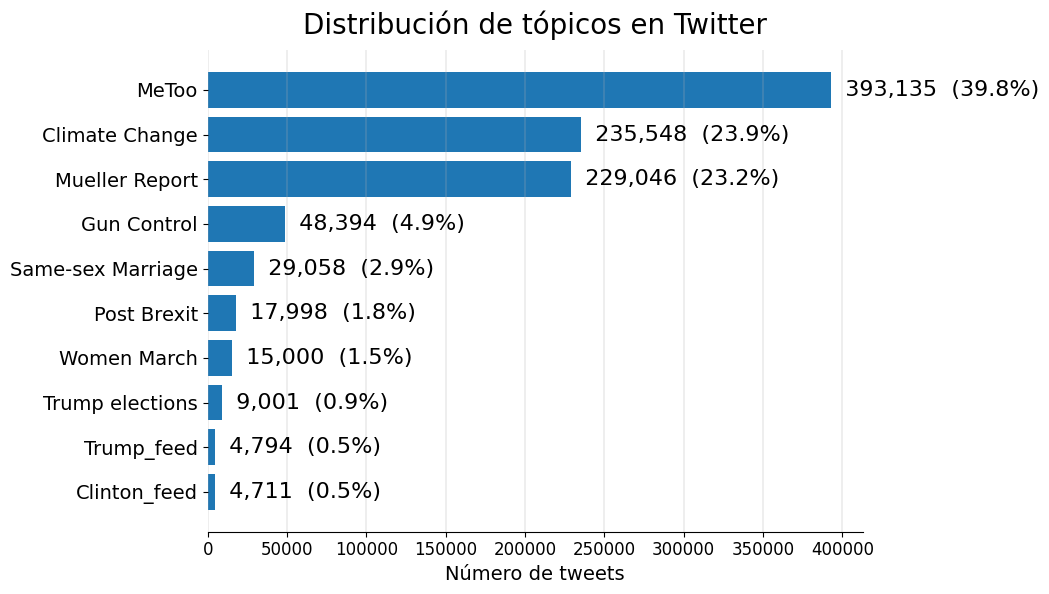

In [30]:
# 1) Datos
counts = twitter_data["Topic_label"].value_counts(dropna=False)

# (Opcional) Limitar a top N y agrupar el resto en "Otros"
TOP_N = 12
if len(counts) > TOP_N:
    top = counts.iloc[:TOP_N]
    otros = counts.iloc[TOP_N:].sum()
    counts = top.append(pd.Series({"Otros": otros}))

# 2) Preparar orden (ascendente para barh)
counts = counts.sort_values(ascending=True)

# 3) Gráfico limpio para PPT
fig, ax = plt.subplots(figsize=(10, 6))  # ajusta tamaño según tu slide
ax.barh(counts.index.astype(str), counts.values)

total = counts.sum()
for i, (label, val) in enumerate(counts.items()):
    pct = val / total * 100
    ax.text(val, i, f"  {val:,}  ({pct:.1f}%)", va='center', fontsize=16)  # etiquetas al final

# 4) Estética minimal
ax.set_title("Distribución de tópicos en Twitter", fontsize=20, pad=12)
ax.set_xlabel("Número de tweets", fontsize = 14)
ax.set_ylabel("")
ax.grid(axis="x", linewidth=0.3)
for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)
plt.tight_layout()
ax.tick_params(axis='y', labelsize=14)  # eje Y
ax.tick_params(axis='x', labelsize=12)  # eje X

plt.show()


## Moral Foundations Dictionary

cargar wmodel y parsearlo a un formato json legible

In [10]:
lines = Path("moral_foundations_dictionary/Moral Foundations Dictionary.wmodel").read_text(encoding="utf-8", errors="ignore").splitlines()

# Encabezados como "CARE.VIRTUE" o "SANCTITY.VICE"
cat_re  = re.compile(r'^\s*([A-Z]+)\.(VIRTUE|VICE)\s*$')
# Términos como "ALTRUISM (1)" (ignora comentarios/otros)
term_re = re.compile(r'^\s*([^\s#;].*?)\s*\(\d+\)\s*$')

mfd = defaultdict(lambda: {"virtue": [], "vice": []})
current = None  # (foundation, valence)

for line in lines:
    m = cat_re.match(line)
    if m:
        foundation = m.group(1).lower()   # care, fairness, ...
        valence    = m.group(2).lower()   # virtue / vice
        current = (foundation, valence)
        continue

    if current:
        t = term_re.match(line)
        if t:
            term = t.group(1).strip()
            mfd[current[0]][current[1]].append(term)

with open("mfd_canonical.json", "w", encoding="utf-8") as f:
    json.dump(mfd, f, ensure_ascii=False, indent=2)


### lista total de palabras morales

In [4]:
with open("moral_foundations_dictionary/mfd_canonical.json", encoding="utf-8") as f:
    mfd = json.load(f)

# Lista completa de palabras (todas las categorías y valencias)
moral_words = sorted({t for v in mfd.values() for terms in v.values() for t in terms})
moral_words = [m.lower() for m in moral_words]


In [4]:
moral_words

['abhor',
 'abhorred',
 'abhors',
 'abstinance',
 'abstinence',
 'abused',
 'abuser',
 'abusers',
 'abuses',
 'abusing',
 'ache',
 'ached',
 'aches',
 'aching',
 'achingly',
 'acquiesce',
 'acquiesced',
 'acquiescent',
 'acquiesces',
 'acquiescing',
 'addict',
 'addicted',
 'addicting',
 'addiction',
 'addictions',
 'addicts',
 'adhere',
 'adhered',
 'adherence',
 'adheres',
 'adhering',
 'admiral',
 'admirals',
 'adulterer',
 'adulterers',
 'adulterous',
 'adultery',
 'afflict',
 'afflicted',
 'affliction',
 'afflictions',
 'afflicts',
 'against_us',
 'agonize',
 'agonized',
 'agonizing',
 'agonizingly',
 'agony',
 'alcoholic',
 'alcoholics',
 'alcoholism',
 'allah',
 'allegiance',
 'allegiances',
 'allegiant',
 'alleviate',
 'alleviated',
 'alleviates',
 'alleviating',
 'alleviation',
 'allied',
 'allies',
 'ally',
 'all_for_one',
 'almighty',
 'altruism',
 'altruist',
 'am_partial',
 'anarchist',
 'anarchistic',
 'anarchists',
 'anarchy',
 'angel',
 'anguish',
 'anguished',
 'anguis

In [5]:
"communities" in moral_words

True

In [41]:
"should" in moral_words

False

In [42]:
"must" in moral_words

False

In [43]:
"president" in moral_words

True

In [44]:
"health" in moral_words

True

In [45]:
"integrity" in moral_words

True

In [46]:
len(moral_words)

2041

In [4]:
def ensure_nltk_data():
    # WordNet (lematizador)
    try:
        nltk.data.find('corpora/wordnet')
    except LookupError:
        nltk.download('wordnet')
    try:
        nltk.data.find('corpora/omw-1.4')
    except LookupError:
        nltk.download('omw-1.4')

    # POS tagger (nombre nuevo en 3.8+, y antiguo por compat.)
    try:
        nltk.data.find('taggers/averaged_perceptron_tagger_eng')
    except LookupError:
        try:
            nltk.download('averaged_perceptron_tagger_eng')
        except Exception:
            # fallback a la versión anterior
            try:
                nltk.data.find('taggers/averaged_perceptron_tagger')
            except LookupError:
                nltk.download('averaged_perceptron_tagger')

ensure_nltk_data()


[nltk_data] Downloading package wordnet to /Users/diego/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/diego/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


incluir lemas dentro del diccionario

In [5]:
lemmatizer = WordNetLemmatizer()

def _wn_pos(tag: str):
    if tag.startswith('J'): return wordnet.ADJ
    if tag.startswith('V'): return wordnet.VERB
    if tag.startswith('N'): return wordnet.NOUN
    if tag.startswith('R'): return wordnet.ADV
    return wordnet.NOUN  # por defecto

def lemmatize_token_list_nltk(tokens, *, min_len=2, drop_numeric=True):
    """Lematiza una lista de tokens en inglés usando POS tags."""
    # filtros opcionales
    toks = [t.lower() for t in tokens
            if (len(t) >= min_len) and (not (drop_numeric and t.isnumeric()))]
    # POS tagging y lematización
    pos = nltk.pos_tag(toks)
    return [lemmatizer.lemmatize(w, _wn_pos(p)).lower() for w, p in pos]

moral_words = np.unique(moral_words + lemmatize_token_list_nltk(moral_words))

In [5]:
"abused" in moral_words

True

### por categorías

In [7]:
# 1) Diccionario por FOUNDATION (unifica virtue y vice)
by_foundation = {
    foundation: sorted({t for terms in valences.values() for t in terms})
    for foundation, valences in mfd.items()
}

# 2) Diccionario por PAIR (foundation.valence)
by_pairs = {
    f"{foundation}.{valence}": sorted(set(terms))
    for foundation, valences in mfd.items()
    for valence, terms in valences.items()
}

# (Opcional) Controles rápidos
print("FOUNDATIONS:", {k: len(v) for k, v in by_foundation.items()})
print("PAIRS:", {k: len(v) for k, v in by_pairs.items()})

FOUNDATIONS: {'care': 464, 'fairness': 351, 'loyalty': 192, 'authority': 431, 'sanctity': 660}
PAIRS: {'care.virtue': 182, 'care.vice': 288, 'fairness.virtue': 115, 'fairness.vice': 236, 'loyalty.virtue': 143, 'loyalty.vice': 49, 'authority.virtue': 301, 'authority.vice': 130, 'sanctity.virtue': 272, 'sanctity.vice': 388}


In [15]:
sum([len(v) for _, v in by_foundation.items()])

2098

In [16]:
foundations_total_list = []
for word_list in [list(v) for _, v in by_foundation.items()]:
    foundations_total_list += word_list



In [17]:
len(np.unique(foundations_total_list))

2041

### Conteo de palabras morales

In [8]:
twitter_data.head(5)

,n_replies,text,text_clean,text_lemma,Topic_label,id,body_words,all_body_words,Distinctly.Emotoinal,Distinctly.Moral,...,party,ACount_unq,MCount_unq,shared,posCount_unq,shared_pos,negCount_unq,shared_neg,channel,day
0,1388,"Over 1,100,000 people killed by guns in the US...",people killed guns usa since @johnlennon shot ...,people kill gun usa since @johnlennon shoot ki...,Gun Control,1.0,11,20,0,0,...,1.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,Twitter,2015-12-01
1,762,"Over 1,100,000 people killed by guns in the US...",people killed guns usa since @johnlennon shot ...,people kill gun usa since @johnlennon shoot ki...,Gun Control,2.0,11,20,0,0,...,NaN,0.0,0.0,2.0,0.0,0.0,0.0,2.0,Twitter,2015-12-01
2,748,If liberals won't punish an entire religion fo...,liberals punish entire religion actions insist...,liberal punish entire religion action insist p...,Gun Control,3.0,9,23,0,1,...,1.0,1.0,1.0,2.0,1.0,0.0,0.0,2.0,Twitter,2015-12-01
3,436,"""@JenniferJJacobs: Trump: ""Protect the 2nd ame...",@jenniferjjacobs trump protect 2nd amendment w...,@jenniferjjacobs trump protect 2nd amendment w...,Gun Control,4.0,10,17,1,1,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,Twitter,2015-12-01
4,342,Kurt Russell put gun control activists on blas...,kurt russell put gun control activists blast r...,kurt russell put gun control activist blast re...,Gun Control,5.0,9,14,0,1,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Twitter,2015-12-01


In [6]:
def moral_counter(tokens, moral_words):
    """
    Conteo de palabras morales
    """
    return sum([1 if token in moral_words else 0 for token in tokens])

In [7]:
twitter_data["text"].astype(str).values

array(['Over 1,100,000 people killed by guns in the USA since @JohnLennon was shot and killed on Dec 8 1980\r\n#StopGunViolence https://t<U+2026>',
       'Over 1,100,000 people killed by guns in the USA since @JohnLennon was shot and killed on Dec 8 1980\r\n#StopGunViolence https:<U+2026>',
       'If liberals won\'t punish an entire religion for "the actions of a few," why do they insist on punishing all gun owners <U+2026>',
       ...,
       "We've come too far to let Republicans take us back. Commit to vote or caucus for Hillary. https://t.co/Y4YpLTep2Z https://t.co/qfLXZEieYJ",
       'Trump says he hires the best people. This is what he means: https://t.co/FvCVcmLLCY',
       "Helping small businesses succeed is about more than policy<U+2014>it's personal. https://t.co/mHmnin9sOR https://t.co/x0HTkkomBQ"],
      shape=(986685,), dtype=object)

## Word Embeddings

In [8]:
from gensim.models import KeyedVectors

# gensim puede leer .bin.gz directo; usa mmap='r' para no cargar todo a RAM de golpe
path_embedding = "word_embeddings/GoogleNews-vectors-negative300.bin.gz"
kv = KeyedVectors.load_word2vec_format(path_embedding, binary=True)


In [9]:
def get_representation_vector(kv, words, fill="zeros"):
    """fill: 'zeros' => devuelve vector 0 si no hay tokens válidos
             'nan'   => devuelve NaN (evítalo si usarás sklearn)
             'none'  => devuelve None y lo saltas afuera
    """
    vecs = [kv.get_vector(w.lower())
            for w in words
            if '_' not in w and kv.has_index_for(w.lower())]
    if not vecs:
        if fill == "zeros":
            return np.zeros(kv.vector_size, dtype=np.float32)
        if fill == "nan":
            return np.full(kv.vector_size, np.nan, dtype=np.float32)
        if fill == "none":
            return None
    M = np.vstack(vecs)
    return M.mean(axis=0)

In [10]:
from sklearn.metrics.pairwise import cosine_similarity 

moral_words_vector = get_representation_vector(kv, moral_words)

## Pre-procesamiento de texto y tokenizadores

In [11]:
# --- Patrones de limpieza ---
URL_RE        = re.compile(r"https?://\S+|www\.\S+", flags=re.IGNORECASE)
MENTION_RE    = re.compile(r"@\w+")
HASHTAG_ALL   = re.compile(r"#([A-Za-z0-9_]+)")
EMOTICON_RE   = re.compile(r"(?:(?::|;|=|x)[-^']?[)D\(POo/\\]|<3)", flags=re.IGNORECASE)
HTML_ENT_RE   = re.compile(r"&\w+;")  # &amp; &gt; ...

In [12]:
def split_camel(s: str):
    # "#HappyFriday" -> ["Happy", "Friday"]; si no hay camel, devuelve [s]
    parts = re.findall(r"[A-Z]?[a-z]+|[A-Z]+(?=[A-Z]|$)|\d+", s)
    return [p for p in parts if p]

def clean_message_en(text: str,
                   keep_hashtag_word: bool = True,
                   split_hashtag_camel: bool = True,
                   remove_emoji: bool = True,
                   demojize: bool = False) -> str:
    text = text.replace("\n", " ")
    text = re.sub(r"\bRT\b", " ", text, flags=re.IGNORECASE)

    text = URL_RE.sub(" ", text)
    text = MENTION_RE.sub(" ", text)

    # Hashtags: conserva palabra (sin #) y opcionalmente separa CamelCase
    def _hashtag_sub(m):
        tok = m.group(1)
        if not keep_hashtag_word:
            return " "
        if split_hashtag_camel:
            return " " + " ".join(split_camel(tok)) + " "
        return " " + tok + " "
    text = HASHTAG_ALL.sub(_hashtag_sub, text)

    text = EMOTICON_RE.sub(" ", text)
    if demojize:
        text = emoji.demojize(text)     # 🙂 -> :slightly_smiling_face:
    if remove_emoji:
        text = emoji.replace_emoji(text, replace=" ")

    text = HTML_ENT_RE.sub(" ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def normalize_repetitions(token: str, max_repeat: int = 2) -> str:
    # "coooool" -> "coool" (limita repeticiones)
    return re.sub(r"(.)\1{" + str(max_repeat) + r",}", r"\1" * max_repeat, token)

# Tokenizador para inglés: letras + CONTRACCIONES (don't, I'm)
TOKENIZER = RegexpTokenizer(r"[A-Za-z]+(?:'[A-Za-z]+)?")

def tokenize_en(text: str):
    toks = TOKENIZER.tokenize(text.lower())
    return [normalize_repetitions(t) for t in toks]

## Análisis twitter

In [13]:
# 1) Limpieza
clean_text = twitter_data["text"].astype(str).apply(
    lambda s: clean_message_en(
        s,
        keep_hashtag_word=True,    # conserva palabras de hashtags
        split_hashtag_camel=True,  # #HappyFriday -> "Happy Friday"
        remove_emoji=True,         # elimina emojis; usa demojize=True si quieres alias
        demojize=False
    )
)

# 2) Tokenización
docs_twitter = clean_text.apply(tokenize_en)

# 3) Filtros finales (opcional)
docs_twitter = docs_twitter.apply(lambda doc: [t for t in doc if not t.isnumeric() and len(t) > 1])

# Si necesitas lista de listas:
docs_twitter = docs_twitter.tolist()

In [14]:
docs_twitter[0]

['over',
 'people',
 'killed',
 'by',
 'guns',
 'in',
 'the',
 'usa',
 'since',
 'was',
 'shot',
 'and',
 'killed',
 'on',
 'dec',
 'stop',
 'gun',
 'violence']

In [15]:
twitter_data["message_len"] = [len(doc) for doc in docs_twitter]
twitter_data["moral_loading"] = [moral_counter(doc, moral_words) for doc in docs_twitter]
twitter_data["moral_density"] = twitter_data["moral_loading"] / twitter_data["message_len"]

In [16]:
twitter_data["moral_loading"].describe()

count    986685.000000
mean          0.725738
std           1.032328
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          21.000000
Name: moral_loading, dtype: float64

In [15]:
twitter_data[twitter_data["text"].str.contains("sexual abuse is wrong", case=False, na=False, regex=False)]

,n_replies,text,text_clean,text_lemma,Topic_label,id,body_words,all_body_words,Distinctly.Emotoinal,Distinctly.Moral,...,shared,posCount_unq,shared_pos,negCount_unq,shared_neg,channel,day,message_len,moral_loading,moral_density
668709,0,Honorable men don't have to have a daughter to...,honorable men daughter know sexual abuse wrong...,honorable man daughter know sexual abuse wrong...,MeToo,10355708.0,10,22,1,0,...,NaN,NaN,NaN,NaN,NaN,Twitter,42928.939583,20,3,0.150000
738290,14,As long as we keep acting like sexual abuse is...,long keep acting like sexual abuse wrong abuse...,long keep act like sexual abuse wrong abuser p...,MeToo,10425289.0,12,21,2,0,...,NaN,NaN,NaN,NaN,NaN,Twitter,43051.981944,21,3,0.142857
738671,14,"""If we keep acting like sexual abuse is wrong ...",keep acting like sexual abuse wrong abuser phy...,keep act like sexual abuse wrong abuser physic...,MeToo,10425670.0,12,19,3,0,...,NaN,NaN,NaN,NaN,NaN,Twitter,43051.973611,19,4,0.210526


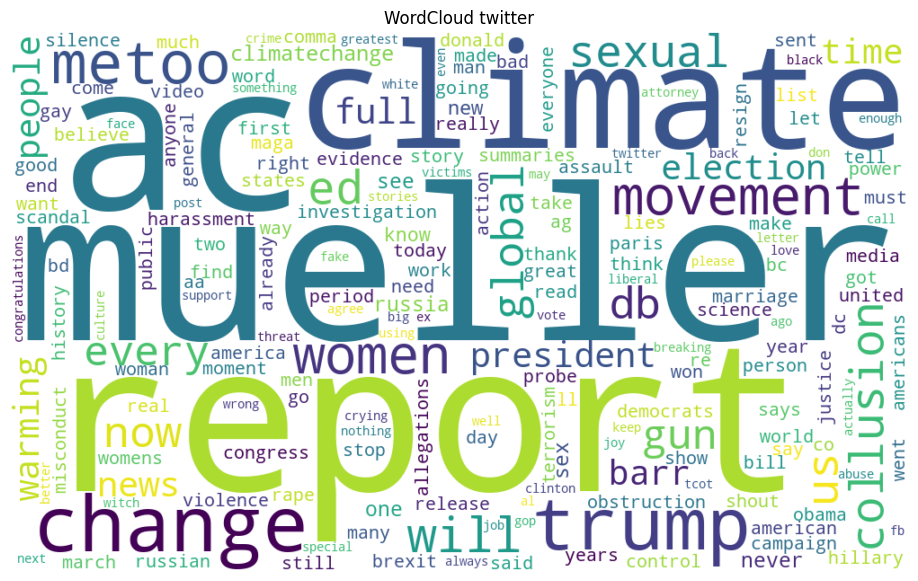

In [129]:
min_len = 2                # longitud mínima de token
solo_alfabetico = True     # descartar tokens con números/símbolos
extra_stopwords = {
    # añade las tuyas; ejemplo en español:
    "https", "http", "rt", "via", "q", "amp"
}
stopwords = set(STOPWORDS) | extra_stopwords

# --- Aplanar y filtrar ---
tokens = [tok for tw in docs_twitter for tok in tw]
if solo_alfabetico:
    tokens = [t for t in tokens if t.isalpha()]
tokens = [t.lower() for t in tokens if len(t) >= min_len and t.lower() not in stopwords]

freqs = Counter(tokens)  # {'hola': 3, 'mundo': 2, ...}

wc_freq = WordCloud(
    width=1000, height=600,
    background_color="white"
).generate_from_frequencies(freqs)

plt.figure(figsize=(12,7))
plt.imshow(wc_freq, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud twitter")
plt.show()


In [20]:
#twitter_plots_data = twitter_data[twitter_data["Topic_label"] == 'Gun Control'].copy()
twitter_plots_data = twitter_data.copy()

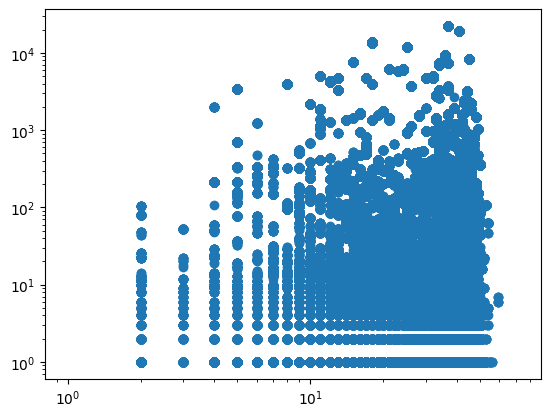

In [40]:
example = twitter_data[twitter_data["Topic_label"] == 'Mueller Report'].copy()
#example = example[(example["moral_ratio"]>=0.25) & (example["moral_ratio"]<=0.5)]

fig, ax = plt.subplots()
ax.scatter(example["message_len"], example["n_replies"])
ax.set_xscale("log", base=10)
ax.set_yscale("log", base=10)

Text(0, 0.5, 'Frequency')

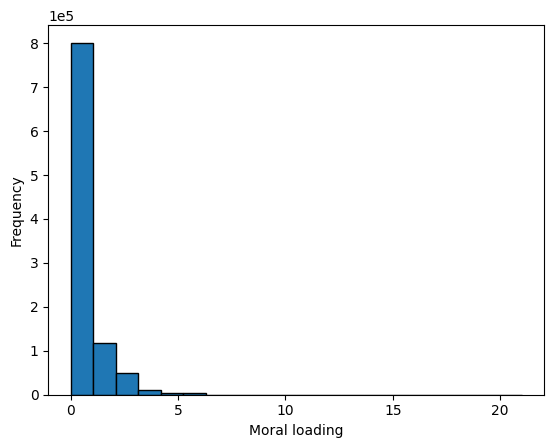

In [86]:
fig, ax = plt.subplots()
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax.hist(twitter_plots_data["moral_loading"], bins=20, edgecolor='k')
plt.xlabel("Moral loading")
plt.ylabel("Frequency")

In [21]:
twitter_plots_data["Topic_label"].unique()

array(['Gun Control', 'Same-sex Marriage', 'Climate Change',
       'Trump elections', 'Women March', 'Post Brexit', 'Mueller Report',
       'MeToo', 'Trump_feed', 'Clinton_feed'], dtype=object)

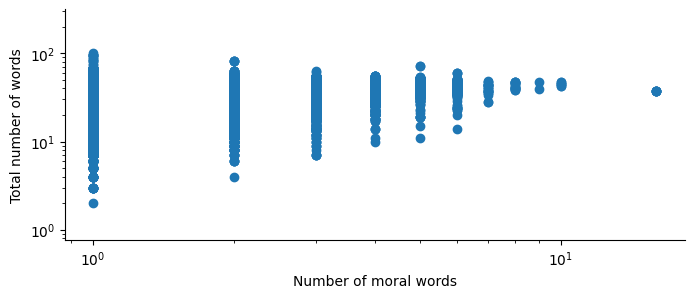

In [82]:
topic_label = 'Mueller Report'
twitter_topic = twitter_plots_data[twitter_plots_data["Topic_label"] == topic_label].copy()

figsize = (8, 3)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = figsize)

ax.scatter(twitter_topic["moral_loading"], twitter_topic["message_len"])
ax.set_xlabel("Number of moral words")
ax.set_ylabel("Total number of words")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yscale('log', base = 10)
ax.set_xscale('log', base = 10)

In [17]:
def plot_topics_grid(df, 
                     axes_labels,
                     topic_col="Topic_label",
                     xcol="moral_loading", ycol="message_len",
                     cols=3, figsize_per_cell=(4,3), suptitle=None,
                     row_gap=0.8, col_gap=0.3,
                     is_ddr = False):
    """
    row_gap: separación vertical entre filas (hspace)
    col_gap: separación horizontal entre columnas (wspace)
    """
    valid = df[(df[xcol] > 0) & (df[ycol] > 0)].copy()
    topics = valid[topic_col].dropna().unique()
    n = len(topics)
    if n == 0:
        raise ValueError("No hay datos positivos para ambas variables en escala log.")

    rows = math.ceil(n / cols)
    fig_w = cols * figsize_per_cell[0]
    fig_h = rows * figsize_per_cell[1]
    fig, axes = plt.subplots(
        rows, cols, figsize=(fig_w, fig_h), squeeze=False, sharex=False, sharey=False,
        gridspec_kw={"hspace": row_gap, "wspace": col_gap}
    )

    xmin, xmax = valid[xcol].min(), valid[xcol].max()
    ymin, ymax = valid[ycol].min(), valid[ycol].max()

    for i, topic in enumerate(sorted(topics)):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        sub = valid[valid[topic_col] == topic]
        ax.scatter(sub[xcol], sub[ycol], alpha=0.6, s=10)
        ax.set_yscale("log", base=10)
        if not is_ddr:
            ax.set_xscale("log", base=10)
        ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
        ax.set_title(str(topic), fontsize=10, pad=6)
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        ax.set_ylabel(axes_labels[1])
        ax.set_xlabel(axes_labels[0])
        #ax.tick_params(axis='both', which='both', labelsize=8, length=3)

    for j in range(n, rows*cols):
        r, c = divmod(j, cols)
        axes[r, c].set_visible(False)

    if suptitle:
        fig.suptitle(suptitle, y=1.02, fontsize=12)

    # Si quieres aún más control tras crear los ejes:
    fig.subplots_adjust(hspace=row_gap, wspace=col_gap)

    return fig, axes

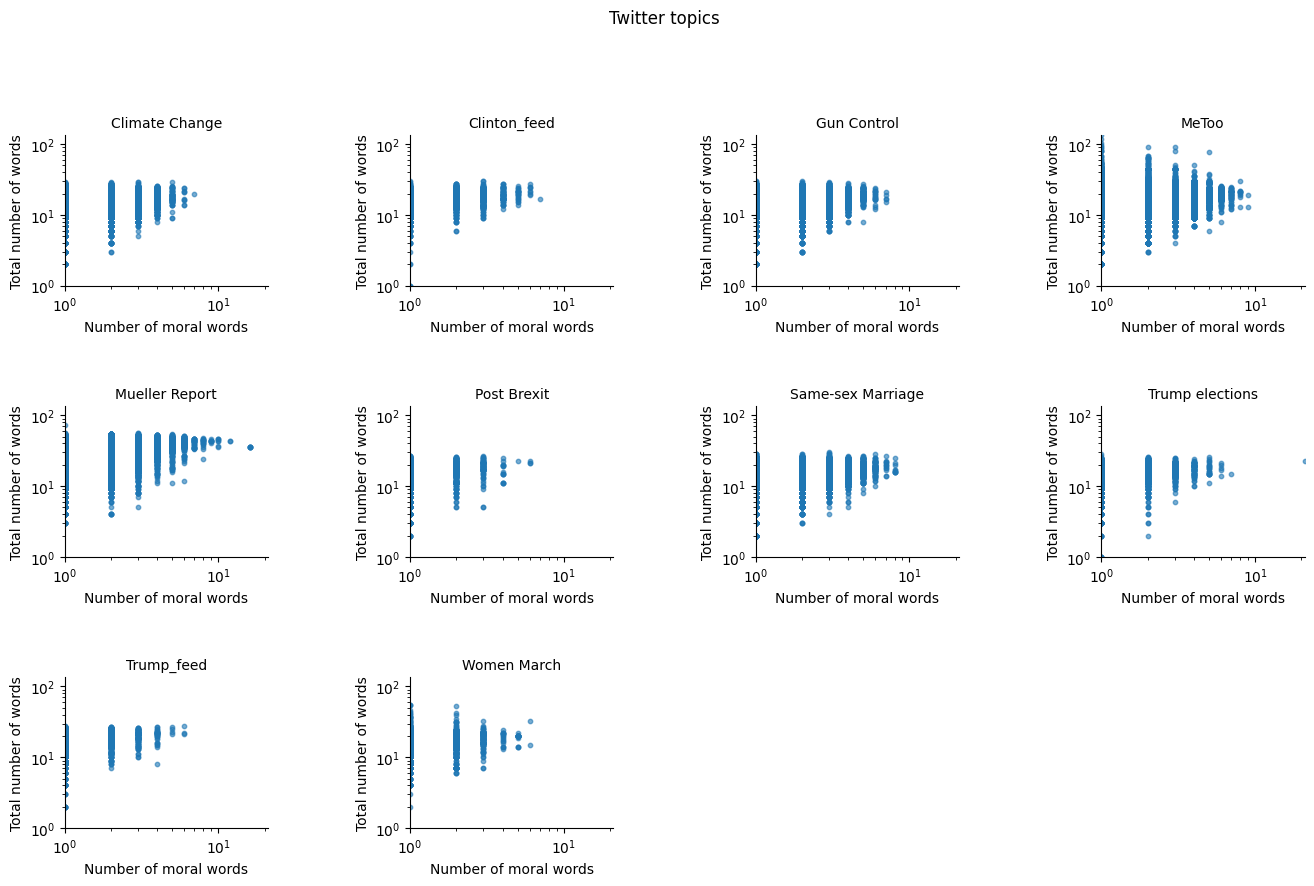

In [16]:
fig, axes = plot_topics_grid(twitter_plots_data, 
                            ["Number of moral words", "Total number of words"],
                            topic_col="Topic_label",
                            xcol="moral_loading", ycol="message_len",
                            cols=4, figsize_per_cell=(4,3),
                            suptitle="Twitter topics",
                            row_gap = 0.8,
                            col_gap = 0.7)
plt.show()

In [18]:
def plot_topics_grid_with_regression(df, 
                     axes_labels,
                     topic_col="Topic_label",
                     xcol="moral_loading", ycol="message_len",
                     cols=3, figsize_per_cell=(4,3), suptitle=None,
                     row_gap=0.8, col_gap=0.3,
                     fit_reg=True,                 # <- NUEVO: dibuja la recta log-log
                     reg_line_kwargs=None,
                     eps = 1,
                     is_ddr = False,
                     engagement_col = 'n_replies'
                     ):    
    """
    row_gap: separación vertical entre filas (hspace)
    col_gap: separación horizontal entre columnas (wspace)
    La regresión se ajusta en log10-space: log10(y) = a + b*log10(x)
    """
    if reg_line_kwargs is None:
        reg_line_kwargs = {'lw': 2, 'alpha': 0.9}

    valid = df.copy()
    topics = valid[topic_col].dropna().unique()
    n = len(topics)
    if n == 0:
        raise ValueError("No hay datos positivos para ambas variables en escala log.")

    rows = math.ceil(n / cols)
    fig_w = cols * figsize_per_cell[0]
    fig_h = rows * figsize_per_cell[1]
    fig, axes = plt.subplots(
        rows, cols, figsize=(fig_w, fig_h), squeeze=False, sharex=False, sharey=False,
        gridspec_kw={"hspace": row_gap, "wspace": col_gap}
    )

    xmin, xmax = valid[xcol].min(), valid[xcol].max()
    ymin, ymax = valid[ycol].min(), valid[ycol].max()

    regressors = {}

    for i, topic in enumerate(sorted(topics)):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        sub = valid[valid[topic_col] == topic]

        # Scatter
        sc = ax.scatter(sub[xcol], sub[ycol],
                   c=np.log10(1+sub[engagement_col]), 
                   cmap=sns.color_palette("rocket", as_cmap=True),
                   marker='.',
                   #alpha = 0.3,
                   linewidths=0, edgecolors='none')
        
        cbar = fig.colorbar(sc, ax=ax)
        cbar.set_label('log(1 + n_replies)')
        ax.set_yscale("log", base=10)
        if not is_ddr:
            ax.set_xscale("log", base=10)
        #ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
        ax.set_title(str(topic), fontsize=16, pad=6)
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        ax.set_ylabel(axes_labels[1], fontsize = 12)
        ax.set_xlabel(axes_labels[0], fontsize = 12)
        
        # Linear regression
        if fit_reg and len(sub) >= 2:
            if not is_ddr:
                X = np.log10(sub[xcol].values + eps).reshape(-1, 1)
            else:
                X = sub[xcol].values.reshape(-1, 1)

            Y = np.log10(sub[ycol].values + eps)

            # filtrar no finitos por seguridad
            mask = np.isfinite(X).ravel() & np.isfinite(Y)
            Xf, Yf = X[mask], Y[mask]

            if len(Xf) >= 2:
                model = LinearRegression()
                model.fit(Xf, Yf)
                slope = float(model.coef_[0])
                intercept = float(model.intercept_)
                regressors[topic] = model
                #r2 = float(model.score(Xf, Yf))

                # Línea en ejes log-log (recta en log10-space)
                if is_ddr:
                    x_grid = np.linspace(0, 1, 200)
                    y_pred = 10 ** (intercept + slope * x_grid)
                else:
                    x_grid = np.logspace(np.log10(eps), np.log10(xmax + eps), 200)
                    y_pred = 10 ** (intercept + slope * np.log10(x_grid)) - eps
                    
                ax.plot(x_grid, y_pred, **reg_line_kwargs)

                ax.text(0.5, 0.3, f"slope={slope:.2f}",
                    transform=ax.transAxes, va='top', ha='left', fontsize=10,
                    bbox=dict(boxstyle='round', fc='white', ec='0.8', alpha=0.8))

    # Ocultar ejes sobrantes
    for j in range(n, rows*cols):
        r, c = divmod(j, cols)
        axes[r, c].set_visible(False)

    if suptitle:
        fig.suptitle(suptitle, y=1.1, fontsize=18)

    fig.subplots_adjust(hspace=row_gap, wspace=col_gap)
    return fig, axes, regressors


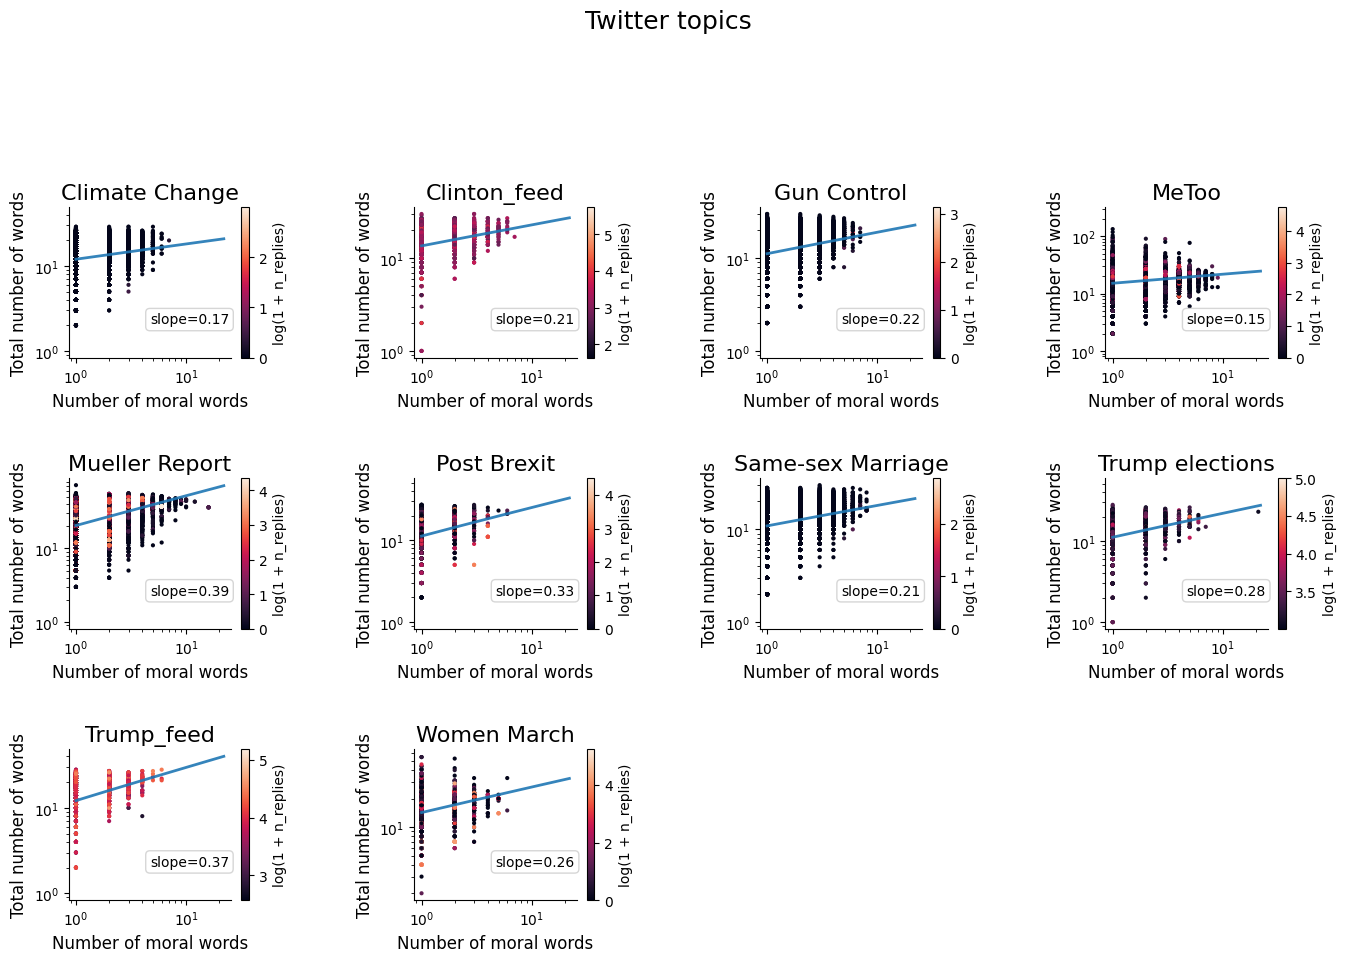

In [21]:
fig, axes, regressors = plot_topics_grid_with_regression(twitter_plots_data, 
                            ["Number of moral words", "Total number of words"],
                            topic_col="Topic_label",
                            xcol="moral_loading", ycol="message_len",
                            cols=4, figsize_per_cell=(4,3),
                            suptitle="Twitter topics",
                            row_gap = 0.8,
                            col_gap = 0.7,
                            eps = 1)
plt.show()

In [56]:
regressors

{'Climate Change': LinearRegression(),
 'Clinton_feed': LinearRegression(),
 'Gun Control': LinearRegression(),
 'MeToo': LinearRegression(),
 'Mueller Report': LinearRegression(),
 'Post Brexit': LinearRegression(),
 'Same-sex Marriage': LinearRegression(),
 'Trump elections': LinearRegression(),
 'Trump_feed': LinearRegression(),
 'Women March': LinearRegression()}

In [22]:
def plot_residuals_grid(df,
                        regressors,                 # dict: {topic: sklearn LinearRegression}
                        topic_col="Topic_label",
                        xcol="moral_loading", ycol="message_len",
                        cols=3, figsize_per_cell=(4,3),
                        bins=20, density=False,
                        suptitle="Residuals per topic (log10-space)",
                        row_gap=0.9, col_gap=0.4,
                        eps=1,                   # para coincidir con tu cálculo
                        share_limits=True,          # comparte rango x entre subplots
                        annotate_stats=True,
                        is_ddr=False):
    """
    Dibuja una grilla de histogramas de residuos por tópico.
    Residuo = pred_log10 - obs_log10 (igual que en tu ejemplo).
    """
    # 1) Recolectar residuos por tópico (solo donde haya modelo)
    topics = sorted([t for t in df[topic_col].dropna().unique() if t in regressors])
    if not topics:
        raise ValueError("No hay tópicos que coincidan con claves en 'regressors'.")

    residuals_map = {}
    sub_data_dict = {}
    for t in topics:
        sub = df[df[topic_col] == t]
        x = sub[xcol].to_numpy(dtype=float)
        y = sub[ycol].to_numpy(dtype=float)
        log_y = np.log10(y + eps)

        if not is_ddr:
            eval_x = np.log10(x + eps)
            mask = np.isfinite(eval_x) & np.isfinite(log_y)
            
        else:
            eval_x = x
            mask = np.isfinite(log_y)

        if mask.sum() < 2 or t not in regressors:
                residuals_map[t] = np.array([], dtype=float)
                continue


        model = regressors[t]
        model_input = eval_x[mask].reshape(-1, 1)
        pred = model.predict(model_input).ravel()
        residuals = pred - log_y[mask]
        residuals_map[t] = residuals
        sub_data_dict[t] = sub

    # 2) Preparar figura
    n = len(topics)
    rows = math.ceil(n / cols)
    fig_w = cols * figsize_per_cell[0]
    fig_h = rows * figsize_per_cell[1]
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h), squeeze=False,
                             gridspec_kw={"hspace": row_gap, "wspace": col_gap})

    # 3) Rango común en X para todos los histogramas (opcional)
    if share_limits:
        all_res = np.concatenate([residuals_map[t] for t in topics if residuals_map[t].size > 0])
        if all_res.size > 0:
            rmin, rmax = np.nanmin(all_res), np.nanmax(all_res)
            # margen pequeño para que 0 no quede justo en el borde
            pad = 0.05 * (rmax - rmin + 1e-12)
            common_range = (rmin - pad, rmax + pad)
        else:
            common_range = None
    else:
        common_range = None

    # 4) Dibujar cada histograma
    for i, t in enumerate(topics):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        res = residuals_map[t]
        if res.size > 0:
            ax.hist(res, bins=bins, density=density, range=common_range, edgecolor='k')
        else:
            # sin datos: histograma vacío para mantener la celda consistente
            ax.hist([], bins=bins)

        # Línea vertical en 0
        ax.axvline(0, linestyle='--', linewidth=1)

        # Estética y etiquetas
        ax.set_title(str(t), fontsize=16, pad=6)
        ax.set_xlabel("Residuals", fontsize = 12)
        ax.set_ylabel("Density" if density else "Count", fontsize=12)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

        if annotate_stats and res.size > 0:
            mu = np.mean(res); sd = np.std(res, ddof=1) if res.size > 1 else 0.0
            txt = f"mean={mu:.3f}\nstd={sd:.3f}\nn={res.size}"
            ax.text(0.97, 0.97, txt, transform=ax.transAxes,
                    va='top', ha='right', fontsize=10,
                    bbox=dict(boxstyle='round', fc='white', ec='0.8', alpha=0.8))

    # 5) Ocultar ejes sobrantes
    for j in range(n, rows*cols):
        r, c = divmod(j, cols)
        axes[r, c].set_visible(False)

    if suptitle:
        fig.suptitle(suptitle, y=1.1, fontsize=20)

    fig.tight_layout()

    # 6) Pequeño resumen por tópico
    stats = {
        t: {
            "n": residuals_map[t].size,
            "mean": float(np.mean(residuals_map[t])) if residuals_map[t].size > 0 else np.nan,
            "std": float(np.std(residuals_map[t], ddof=1)) if residuals_map[t].size > 1 else np.nan,
            "min": float(np.min(residuals_map[t])) if residuals_map[t].size > 0 else np.nan,
            "max": float(np.max(residuals_map[t])) if residuals_map[t].size > 0 else np.nan,
        }
        for t in topics
    }

    return fig, axes, residuals_map, sub_data_dict, stats


/var/folders/2h/91q4sd4x3t13f8n_dy5nkj_00000gn/T/ipykernel_1322/2126592470.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


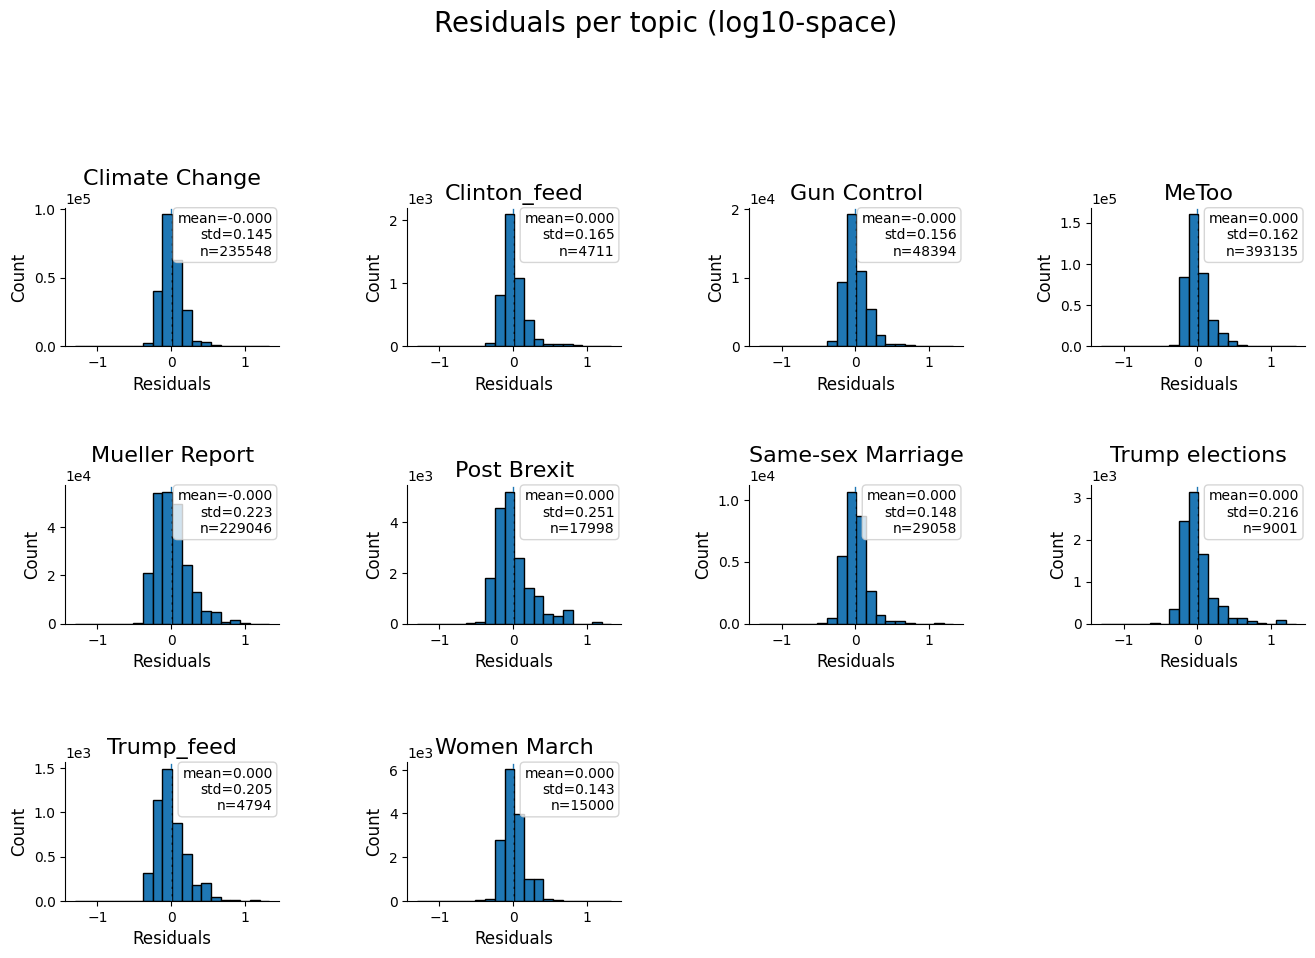

In [23]:
# regressors: dict devuelto por tu función anterior (clave = Topic_label)
fig, axes, residuals_map, sub_data, _ = plot_residuals_grid(
    twitter_plots_data,
    regressors=regressors,
    topic_col="Topic_label",
    xcol="moral_loading", ycol="message_len",
    cols=4, figsize_per_cell=(4,3),
    bins=20, density=False,
    suptitle="Residuals per topic (log10-space)",
    row_gap=1.0, col_gap=0.6,
    eps=1,
    share_limits=True,
    annotate_stats=True
)
plt.show()


In [24]:
def stars(p):
    if p < 0.001: return '***'
    if p < 0.01:  return '**'
    if p < 0.05:  return '*'
    return ''


def fit_and_extract(X, y, vars, model='ols'):
    """
    Devuelve: coef, lo, hi, pvalue y el objeto del modelo
    - OLS: usa y = log10(1 + n_replies)
    - NB : usa y = n_replies (conteos)
    """
    Xc = sm.add_constant(X, has_constant='add')

    if model == "ols":
        y_use = np.log10(1 + y.astype(float))
        res = sm.OLS(y_use, Xc).fit()

    elif model == "nb":
        # Conteos enteros, con ceros permitidos
        y_use = np.asarray(y, dtype=int)

        # 1) Poisson como inicialización
        pois = sm.GLM(y_use, Xc, family=sm.families.Poisson()).fit()

        # 2) start_params: betas Poisson + alpha (NO log(alpha))
        alpha_inicial = 0.1  # prueba luego 0.5, 1.0 si quieres
        start_params = np.append(pois.params, alpha_inicial)

        # 3) Ajustar NB
        mod_nb = NegativeBinomial(y_use, Xc)
        res = mod_nb.fit(
            start_params=start_params,
            method='bfgs',
            maxiter=200,
            disp=False
        )

    else:
        raise ValueError("MODEL debe ser 'ols' o 'nb'.")

    # Extraer coeficientes para las variables pedidas
    b, lo, hi, p = [], [], [], []
    ci = res.conf_int()
    for var in vars:
        b.append(res.params[var])
        lo_temp, hi_temp = ci.loc[var]
        lo.append(lo_temp)
        hi.append(hi_temp)
        p.append(res.pvalues[var])

    return b, lo, hi, p, res

def plot_forest_single(df, ax, title,
                       xlab="Coeficiente", left=-2, right=2):

    sub_df = df.copy()

    # y-positions
    ypos = np.arange(len(sub_df))

    # valores centrales y errores
    x = sub_df["coef"].values
    lo = sub_df["lo"].values
    hi = sub_df["hi"].values
    xerr = np.vstack([x - lo, hi - x])

    # mapa de colores según network
    color_map = {"Twitter": "r", "Reddit": "g"}
    colors = sub_df["network"].map(color_map).values

    # primero las barras de error en gris
    ax.errorbar(
        x, ypos, xerr=xerr,
        fmt='none', lw=1.5, capsize=3,
        ecolor='0.45'
    )

    # luego los puntos coloreados por network
    ax.scatter(
        x, ypos,
        s=50,
        c=colors,
        zorder=3
    )

    # línea vertical en 0
    ax.axvline(0, ls='--', lw=1, color='0.5')

    # eje y con nombres de topic
    ax.set_yticks(ypos)
    ax.set_yticklabels(sub_df["topic"])
    ax.set_xlabel(xlab)
    ax.set_title(title)
    ax.grid(axis='x', alpha=0.25)

    # estrellitas
    for yi, xi, p in zip(ypos, x, sub_df["p"]):
        ax.text(xi, yi + 0.05, stars(p),
                ha='center', va='bottom', fontsize=11)

    ax.set_xlim(left=left, right=right)

    # leyenda de colores
    handles = [
        plt.Line2D([0], [0], marker='o', linestyle='',
                   color='r', label='Twitter'),
        plt.Line2D([0], [0], marker='o', linestyle='',
                   color='g', label='Reddit')
    ]
    ax.legend(handles=handles)





def build_per_topic(model,
                    sub_data,
                    residuals_map,
                    replies_var = 'n_replies',
                    is_ddr = False):
    rows_results = []

    for topic_label in residuals_map.keys():
        topic_data = sub_data[topic_label].copy()
        topic_residuals = residuals_map[topic_label]
        topic_data["residuals"] = topic_residuals
        moral_loading = "log_moral_loading" if not is_ddr else "ddr_moral_loading"
        topic_data[moral_loading] = np.log10(topic_data["moral_loading"]+1) if not is_ddr else topic_data["ddr_moral_loading"]
        moral_density = "moral_density" if not is_ddr else "ddr_moral_density"
        topic_data["log_message_len"] = np.log10(1+topic_data["message_len"])

        # usamos moral_ratio, n_replies, message_len, residuals
        eval_data = topic_data[[moral_density, 
                                moral_loading, 
                                "log_message_len", 
                                "residuals",
                                replies_var]].dropna()

        # corr spearman
        res1 = stats.spearmanr(eval_data["residuals"], eval_data[moral_density])
        res2 = stats.spearmanr(eval_data["log_message_len"], eval_data[moral_density])
        print(f"Topic label: {topic_label}")
        print(f"residuals | moral density: {res1.statistic}\n")

        y = eval_data[replies_var].values
        
        vars = [moral_loading, "residuals"]
        b, lo, hi, p, _ = fit_and_extract(
            eval_data[vars], y, vars=vars, model=model
        )
        rows_results.append(
            pd.DataFrame(
            {"topic": len(vars)*[topic_label], "var": vars, "coef": b, "lo": lo, "hi": hi, "p": p}
            ))

    return pd.concat(rows_results).reset_index(drop=True)



In [25]:
model = 'nb'
coefficients_liwc_twitter = build_per_topic(model, sub_data, residuals_map, is_ddr=False)
coefficients_liwc_twitter["network"] = "Twitter"

Topic label: Climate Change
residuals | moral density: 0.1333630874856591

Topic label: Clinton_feed
residuals | moral density: 0.2542980920050925

Topic label: Gun Control
residuals | moral density: 0.4494133319198252

Topic label: MeToo
residuals | moral density: 0.19594373344536536

Topic label: Mueller Report
residuals | moral density: 0.14750535396016745

Topic label: Post Brexit
residuals | moral density: 0.10950052662381356

Topic label: Same-sex Marriage
residuals | moral density: 0.433490833210347

Topic label: Trump elections
residuals | moral density: 0.2653736706145193

Topic label: Trump_feed
residuals | moral density: 0.17344847678055342

Topic label: Women March
residuals | moral density: 0.16695745231532522



### Moral loading con word embeddings

In [154]:
docs_twitter[6]

['show',
 'your',
 'support',
 'for',
 'common',
 'sense',
 'gun',
 'safety',
 'laws',
 'like',
 'closing',
 'the',
 'no',
 'fly',
 'list',
 'loophole',
 'do',
 'somet']

In [26]:
def get_transformed_similarities(kv, doc, moral_words_vector):
    
    density_computed = []
    for word in doc:
        word_similarity = cosine_similarity(moral_words_vector.reshape(1, -1), get_representation_vector(kv, [word]).reshape(1, -1))[0, 0]
        transformed_similarity = 1/(1+np.exp(-word_similarity+0.84))
        density_computed.append(transformed_similarity)
    if len(density_computed) == 0:
        return None
    return np.mean(density_computed)

In [51]:
twitter_plots_data["ddr_moral_loading"] = [cosine_similarity(moral_words_vector.reshape(1, -1), get_representation_vector(kv, doc).reshape(1, -1))[0, 0] for doc in docs_twitter]
twitter_plots_data["ddr_moral_density"] = twitter_plots_data["ddr_moral_loading"] 

Text(0, 0.5, 'Frequency')

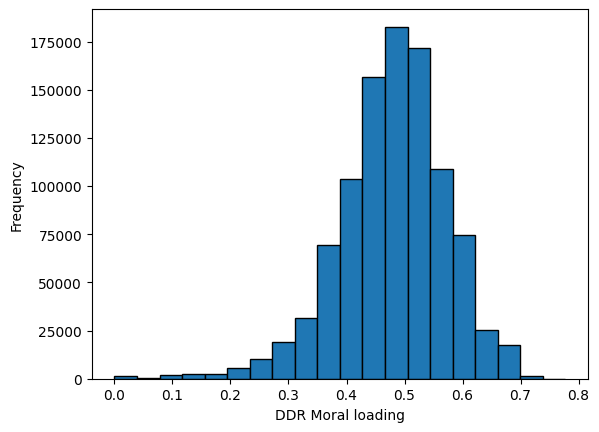

In [75]:
twitter_plots_data["ddr_moral_loading"].hist(bins=20, edgecolor='k', grid=False)
plt.xlabel("DDR Moral loading")
plt.ylabel("Frequency")

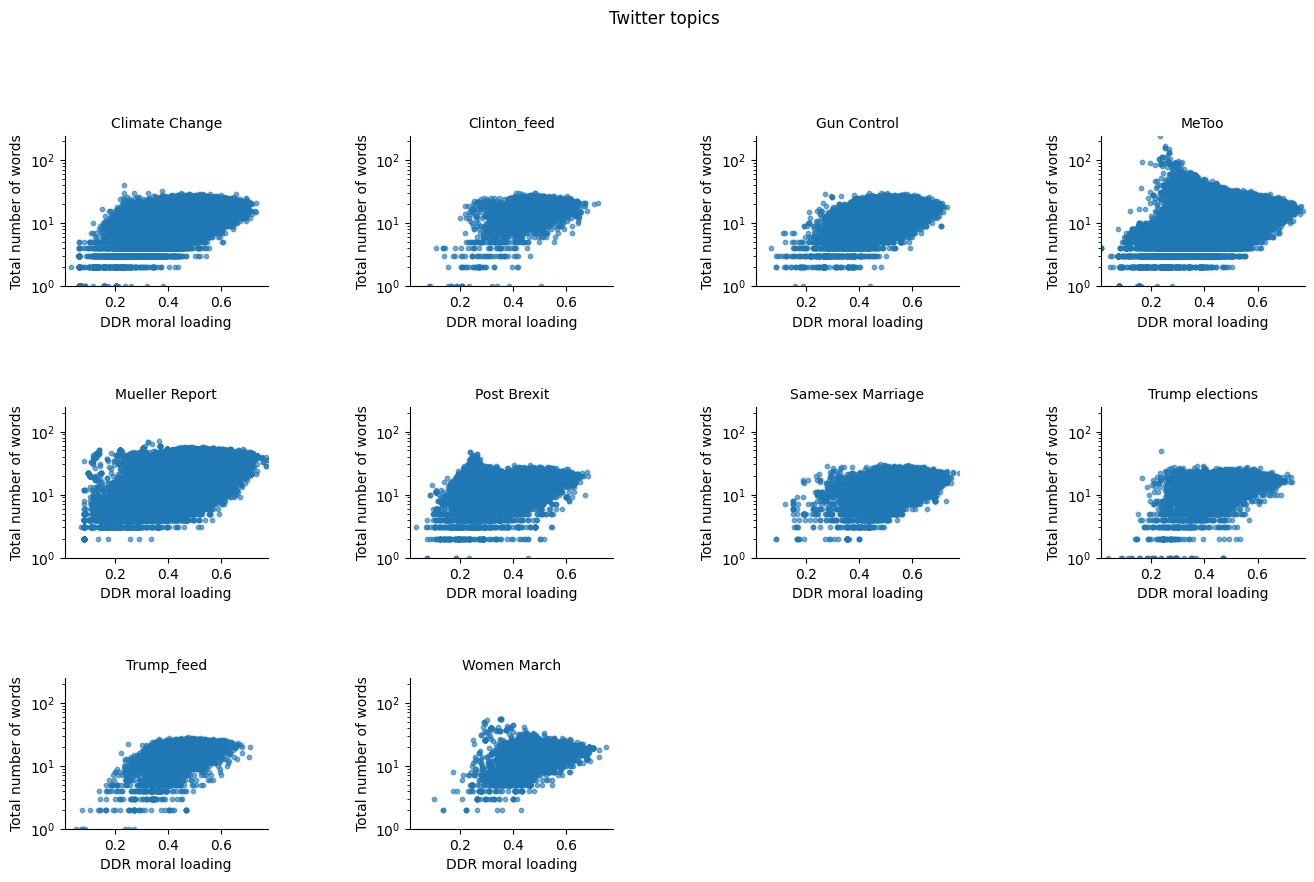

In [64]:
fig, axes = plot_topics_grid(twitter_plots_data, 
                            ["DDR moral loading", "Total number of words"],
                            topic_col="Topic_label",
                            xcol="ddr_moral_loading", ycol="message_len",
                            cols=4, figsize_per_cell=(4,3),
                            suptitle="Twitter topics",
                            row_gap = 0.8,
                            col_gap = 0.7,
                            is_ddr = True)

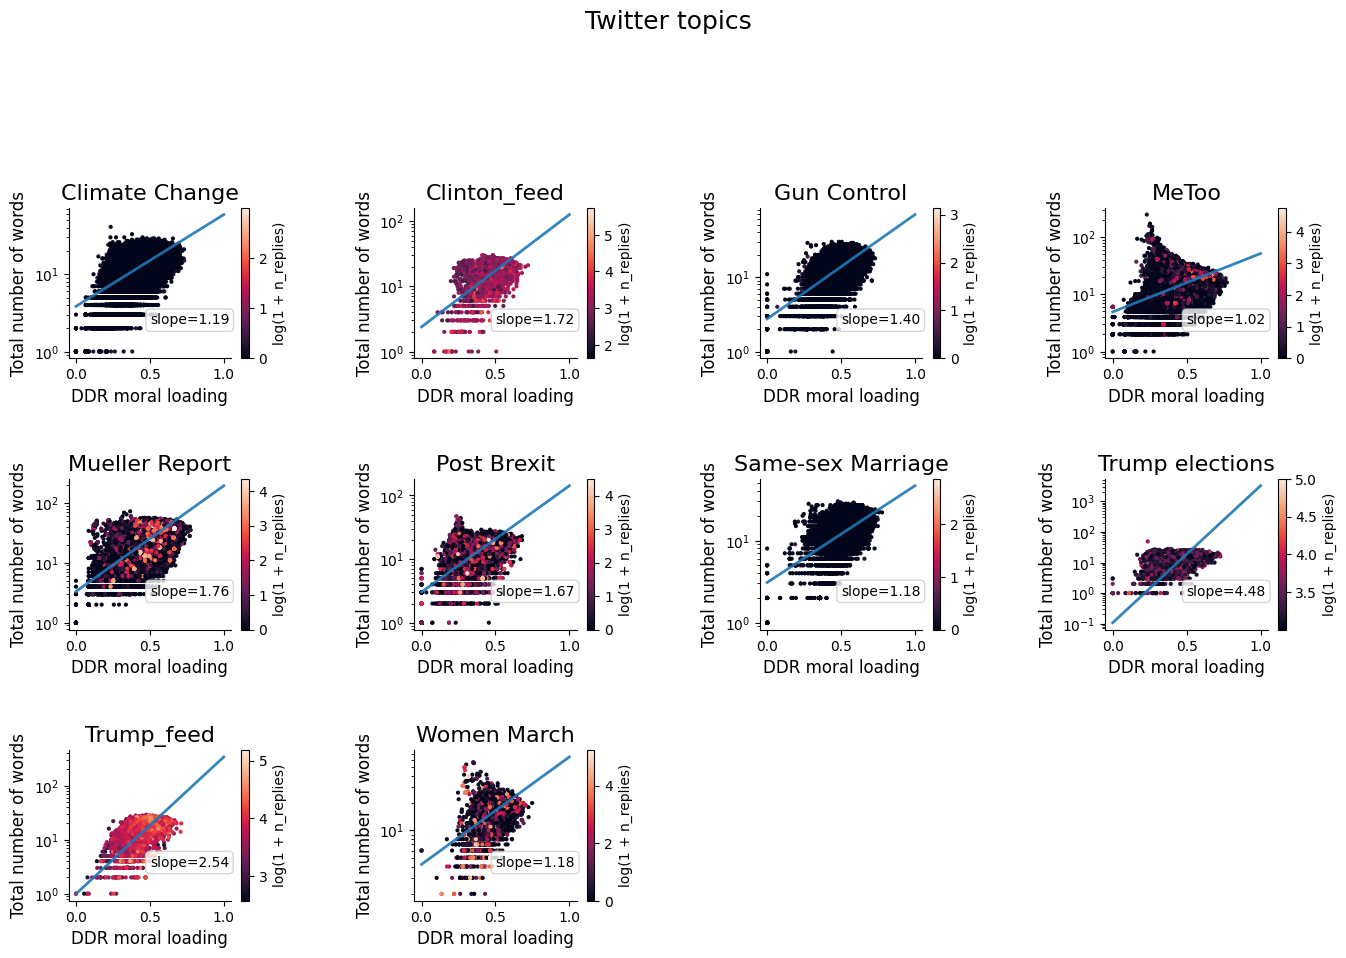

In [52]:
fig, axes, regressors = plot_topics_grid_with_regression(twitter_plots_data, 
                            ["DDR moral loading", "Total number of words"],
                            topic_col="Topic_label",
                            xcol="ddr_moral_loading", ycol="message_len",
                            cols=4, figsize_per_cell=(4,3),
                            suptitle="Twitter topics",
                            row_gap = 0.8,
                            col_gap = 0.7,
                            eps = 1e-6,
                            is_ddr = True)
plt.show()

/var/folders/2h/91q4sd4x3t13f8n_dy5nkj_00000gn/T/ipykernel_1322/2126592470.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


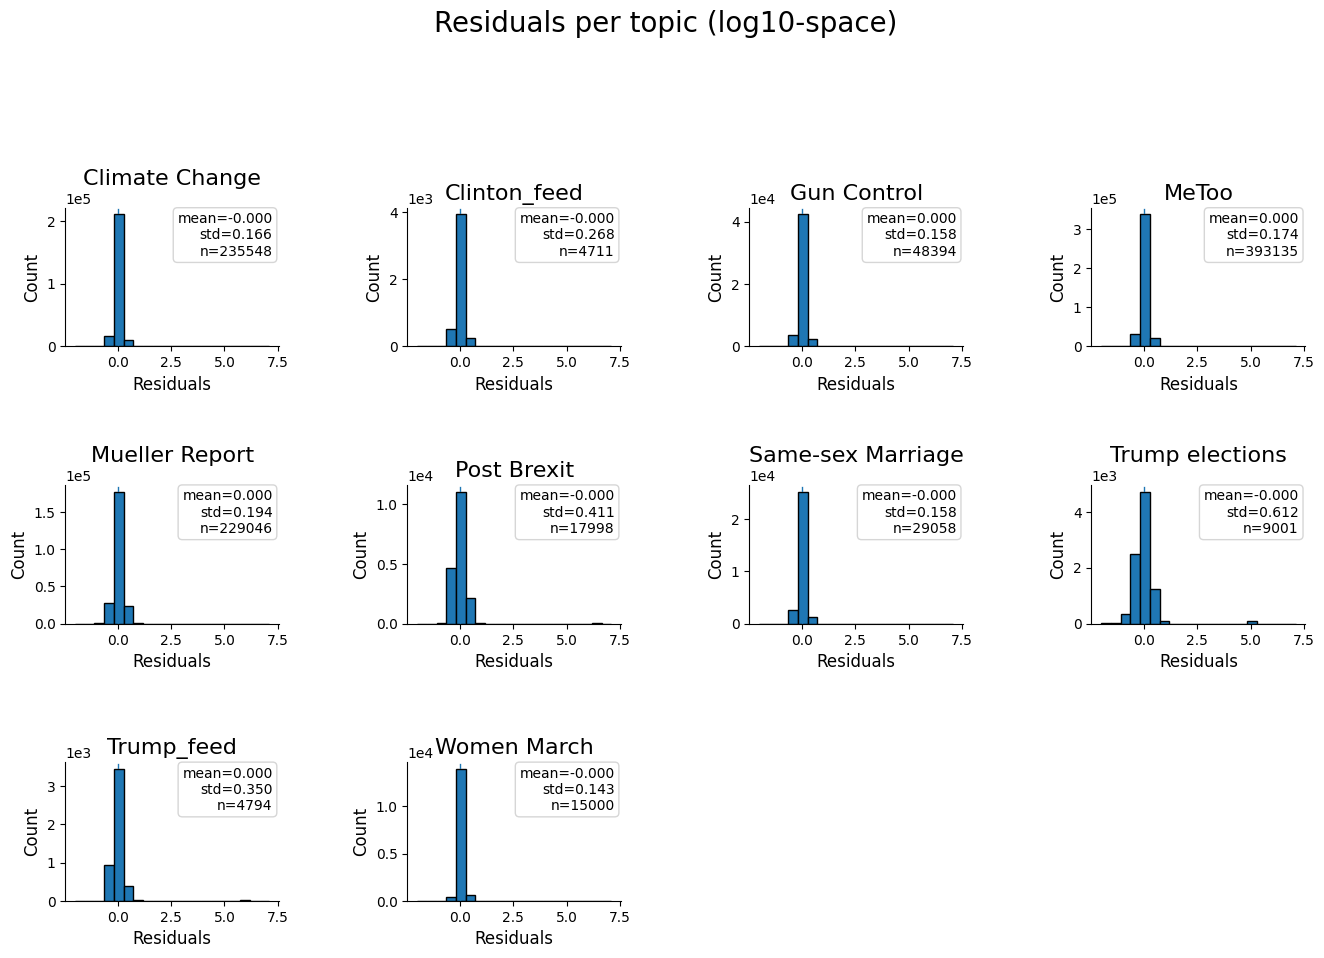

In [53]:
# regressors: dict devuelto por tu función anterior (clave = Topic_label)
fig, axes, residuals_map, sub_data, _ = plot_residuals_grid(
    twitter_plots_data,
    regressors=regressors,
    topic_col="Topic_label",
    xcol="ddr_moral_loading", ycol="message_len",
    cols=4, figsize_per_cell=(4,3),
    bins=20, density=False,
    suptitle="Residuals per topic (log10-space)",
    row_gap=1.0, col_gap=0.6,
    eps=1e-6,
    share_limits=True,
    annotate_stats=True,
    is_ddr = True
)
plt.show()

In [54]:
model = 'nb'
coefficients_ddr_twitter = build_per_topic(model, sub_data, residuals_map, is_ddr=True)
coefficients_ddr_twitter["network"] = "Twitter"

Topic label: Climate Change
residuals | moral density: 0.13335216784097842

Topic label: Clinton_feed
residuals | moral density: 0.3777676110199066

Topic label: Gun Control
residuals | moral density: 0.1520689579601101

Topic label: MeToo
residuals | moral density: 0.1786396870802552

Topic label: Mueller Report
residuals | moral density: 0.0510009388210757

Topic label: Post Brexit
residuals | moral density: 0.32972228201463216

Topic label: Same-sex Marriage
residuals | moral density: 0.105340251527408

Topic label: Trump elections
residuals | moral density: 0.7830835140396327

Topic label: Trump_feed
residuals | moral density: 0.37959971224101946

Topic label: Women March
residuals | moral density: 0.07526423521336882



In [105]:
sub_data["Mueller Report"].columns

Index(['n_replies', 'text', 'text_clean', 'text_lemma', 'Topic_label', 'id',
       'body_words', 'all_body_words', 'Distinctly.Emotoinal',
       'Distinctly.Moral', 'emo_neg', 'emo_pos', 'Moral.emotional', 'Neutral',
       'authority.vice', 'authority.virtue', 'care.vice', 'care.virtue',
       'fairness.vice', 'fairness.virtue', 'loyalty.vice', 'loyalty.virtue',
       'moral_all', 'MoralityGeneral', 'sanctity.vice', 'sanctity.virtue',
       'vice', 'virtue', 'Distinctly.Emotoinal.y', 'Distinctly.Moral.y',
       'emo_neg.y', 'emo_pos.y', 'Moral.emotional.y', 'Neutral.y',
       'authority.vice.y', 'authority.virtue.y', 'care.vice.y',
       'care.virtue.y', 'fairness.vice.y', 'fairness.virtue.y',
       'loyalty.vice.y', 'loyalty.virtue.y', 'moral_all.y',
       'MoralityGeneral.y', 'sanctity.vice.y', 'sanctity.virtue.y', 'vice.y',
       'virtue.y', 'user.verified', 'url', 'media', 'followers', 'topic',
       'src_id', 'ideology', 'hasIdeo', 'party_mean', 'party', 'ACount_unq',

## Análisis Reddit

In [36]:
data_reddit = pd.read_csv("Data/Reddit/Threads_corpus_ALL_Reddit.csv")
data_reddit.drop("Unnamed: 0", axis=1, inplace=True)
data_reddit.head(5)

,created_utc,author_fullname,title,selftext,full_link,total_n_replies,channel,id,is_video,is_original_content,score,media_only,title_thread
0,1590708669,t2_2iyufn,Trump signs social media executive order to re...,NaN,https://www.reddit.com/r/The_Donald/comments/g...,2950,The_Donald,gshffi,False,False,1,False,Trump signs social media executive order to re...
1,1584500691,t2_2iyufn,Veterans Needing Assistance Getting Remote Hea...,If you need help getting setup with the VHA vi...,https://www.reddit.com/r/The_Donald/comments/f...,2,The_Donald,fkille,False,False,1,False,Veterans Needing Assistance Getting Remote Hea...
2,1584397773,t2_qt1ca,President Trump's Coronavirus Guidelines for A...,**15 days to slow the spread** ------ - Listen...,https://www.reddit.com/r/The_Donald/comments/f...,2,The_Donald,fjttfh,False,False,70,False,President Trump's Coronavirus Guidelines for A...
3,1584316486,t2_lea1s1i,WATCH PARTY: Dem(entia) Debate Disaster - Comm...,"#[Welcome back, Centipedes. It’s time for anot...",https://www.reddit.com/r/The_Donald/comments/f...,2,The_Donald,fjb8qw,False,False,1,False,WATCH PARTY: Dem(entia) Debate Disaster - Comm...
4,1584306846,t2_2iyufn,Members of the Coronavirus Task Force Hold a P...,NaN,https://www.reddit.com/r/The_Donald/comments/f...,2,The_Donald,fj8ph7,False,False,1,False,Members of the Coronavirus Task Force Hold a P...


In [37]:
len(data_reddit)

1067832

In [38]:
data_reddit["score"].value_counts()

score
1       479773
2        16117
0        13970
3        10282
19        9671
         ...  
7843         1
7369         1
7526         1
5710         1
4715         1
Name: count, Length: 7527, dtype: int64

In [39]:
data_reddit["channel"].value_counts()

channel
The_Donald      871858
Conservative    166013
Communism        22146
Liberal           7815
Name: count, dtype: int64

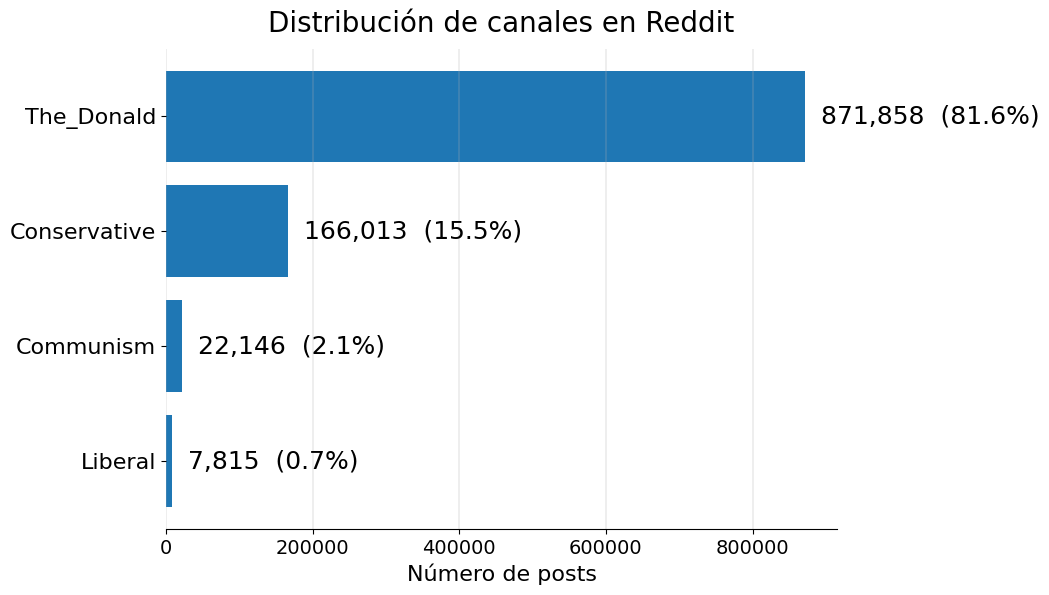

In [33]:
# 1) Datos
counts = data_reddit["channel"].value_counts(dropna=False)

# (Opcional) Limitar a top N y agrupar el resto en "Otros"
TOP_N = 12
if len(counts) > TOP_N:
    top = counts.iloc[:TOP_N]
    otros = counts.iloc[TOP_N:].sum()
    counts = top.append(pd.Series({"Otros": otros}))

# 2) Preparar orden (ascendente para barh)
counts = counts.sort_values(ascending=True)

# 3) Gráfico limpio para PPT
fig, ax = plt.subplots(figsize=(10, 6))  # ajusta tamaño según tu slide
ax.barh(counts.index.astype(str), counts.values)

total = counts.sum()
for i, (label, val) in enumerate(counts.items()):
    pct = val / total * 100
    ax.text(val, i, f"  {val:,}  ({pct:.1f}%)", va='center', fontsize = 18)  # etiquetas al final

# 4) Estética minimal
ax.set_title("Distribución de canales en Reddit", fontsize=20, pad=12)
ax.set_xlabel("Número de posts", fontsize = 16)
ax.set_ylabel("")
ax.grid(axis="x", linewidth=0.3)
for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)
plt.tight_layout()
ax.tick_params(axis='y', labelsize=16)  # eje Y
ax.tick_params(axis='x', labelsize=14)  # eje X

plt.show()

In [49]:
data_reddit.columns

Index(['created_utc', 'author_fullname', 'title', 'selftext', 'full_link',
       'total_n_replies', 'channel', 'id', 'is_video', 'is_original_content',
       'score', 'media_only', 'title_thread'],
      dtype='object')

In [50]:
data_reddit["title"].head(5).values[1]

'Veterans Needing Assistance Getting Remote Healthcare'

In [51]:
data_reddit["selftext"].head(5).values[1]

"If you need help getting setup with the VHA via telehealth or MyHealtheVet messaging, feel free to DM me and I will assist you setting up a user, teach you how to use the site or app, and get you connected to your docs so you don't have to go into a facility unless 100% necessary. There is absolutely no need for Veterans to go into VHA facilities right now for anything that can be done remotely, including refilling prescriptions, seeing a doctor for a non-emergency, having a Behavioral Health clinic appointment, etc.. They are starting to screen people and limit access at many VHA Hospitals and Clinics. So, message me and let's get you set so we can keep you healthy. [Go here for comments and to contact me](https://thedonald.win/p/FMA99ZAn/veterans-needing-assistance-gett/)"

In [138]:
data_reddit["title_thread"].head(5).values[1]

"Veterans Needing Assistance Getting Remote Healthcare. If you need help getting setup with the VHA via telehealth or MyHealtheVet messaging, feel free to DM me and I will assist you setting up a user, teach you how to use the site or app, and get you connected to your docs so you don't have to go into a facility unless 100% necessary. There is absolutely no need for Veterans to go into VHA facilities right now for anything that can be done remotely, including refilling prescriptions, seeing a doctor for a non-emergency, having a Behavioral Health clinic appointment, etc.. They are starting to screen people and limit access at many VHA Hospitals and Clinics. So, message me and let's get you set so we can keep you healthy. [Go here for comments and to contact me](https://thedonald.win/p/FMA99ZAn/veterans-needing-assistance-gett/)"

In [140]:
null_text = sum(data_reddit["selftext"].isnull())
total = len(data_reddit)

print(f'Número total con null selftext: {null_text}')
print(f'Número total de datos: {total}')

Número total con null selftext: 952367
Número total de datos: 1067832


In [40]:
# 1) Limpieza
clean_text = data_reddit["title"].astype(str).apply(
    lambda s: clean_message_en(
        s,
        keep_hashtag_word=True,    # conserva palabras de hashtags
        split_hashtag_camel=True,  # #HappyFriday -> "Happy Friday"
        remove_emoji=True,         # elimina emojis; usa demojize=True si quieres alias
        demojize=False
    )
)

# 2) Tokenización
docs_reddit = clean_text.apply(tokenize_en)

# 3) Filtros finales (opcional)
docs_reddit = docs_reddit.apply(lambda doc: [t for t in doc if not t.isnumeric() and len(t) > 1])

# Si necesitas lista de listas:
docs_reddit = docs_reddit.tolist()

In [41]:
docs_reddit[0]

['trump',
 'signs',
 'social',
 'media',
 'executive',
 'order',
 'to',
 'revoke',
 'liability',
 'protections',
 'from',
 'bias',
 'social',
 'media',
 'publishers']

In [42]:
data_reddit["message_len"] = [len(doc) for doc in docs_reddit]
data_reddit["moral_loading"] = [moral_counter(doc, moral_words) for doc in docs_reddit]
data_reddit["moral_density"] = data_reddit["moral_loading"] / data_reddit["message_len"]

In [43]:
reddit_plots_data = data_reddit.copy()

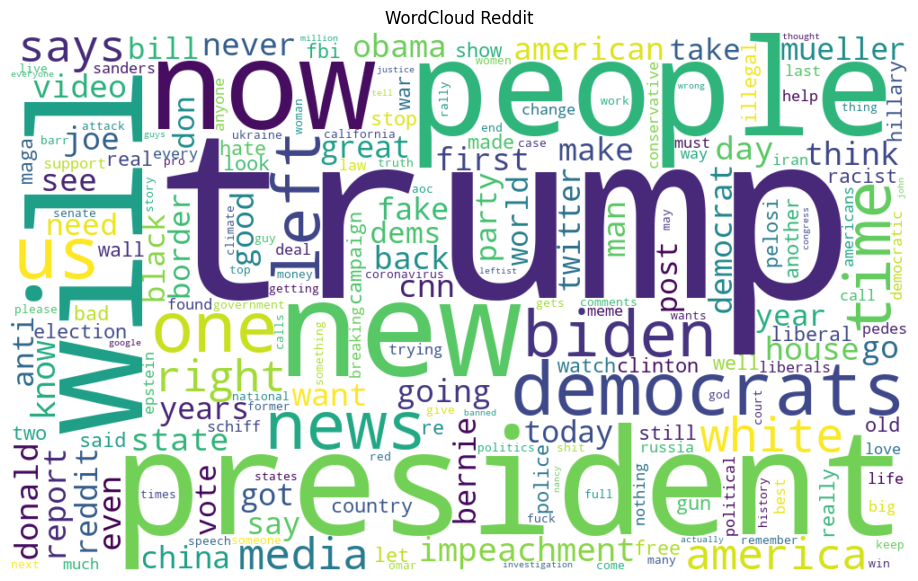

In [146]:
min_len = 2                # longitud mínima de token
solo_alfabetico = True     # descartar tokens con números/símbolos
extra_stopwords = {
    # añade las tuyas; ejemplo en español:
    "https", "http", "rt", "via", "q", "amp"
}
stopwords = set(STOPWORDS) | extra_stopwords

# --- Aplanar y filtrar ---
tokens = [tok for tw in docs_reddit for tok in tw]
if solo_alfabetico:
    tokens = [t for t in tokens if t.isalpha()]
tokens = [t.lower() for t in tokens if len(t) >= min_len and t.lower() not in stopwords]

freqs = Counter(tokens)  # {'hola': 3, 'mundo': 2, ...}

wc_freq = WordCloud(
    width=1000, height=600,
    background_color="white"
).generate_from_frequencies(freqs)

plt.figure(figsize=(12,7))
plt.imshow(wc_freq, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud Reddit")
plt.show()

Text(0, 0.5, 'Frequency')

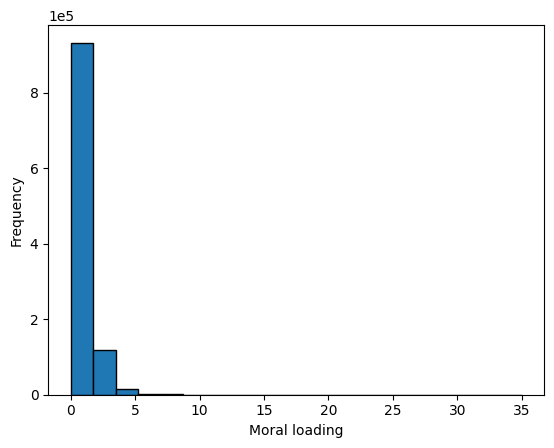

In [87]:
fig, ax = plt.subplots()
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax.hist(reddit_plots_data["moral_loading"], bins=20, edgecolor='k')
plt.xlabel("Moral loading")
plt.ylabel("Frequency")

### Incorporar word embedding

In [56]:
reddit_plots_data["ddr_moral_loading"] = [cosine_similarity(moral_words_vector.reshape(1, -1), get_representation_vector(kv, doc).reshape(1, -1))[0, 0] for doc in docs_reddit]
reddit_plots_data["ddr_moral_density"] = reddit_plots_data["ddr_moral_loading"]

Text(0, 0.5, 'Frequency')

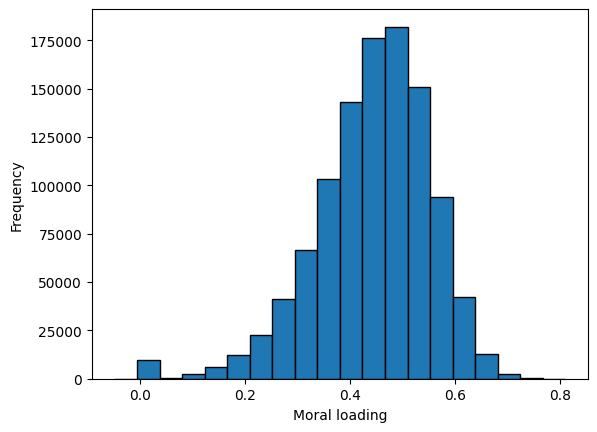

In [59]:
reddit_plots_data["ddr_moral_loading"].hist(bins=20, edgecolor='k', grid=False)
plt.xlabel("Moral loading")
plt.ylabel("Frequency")

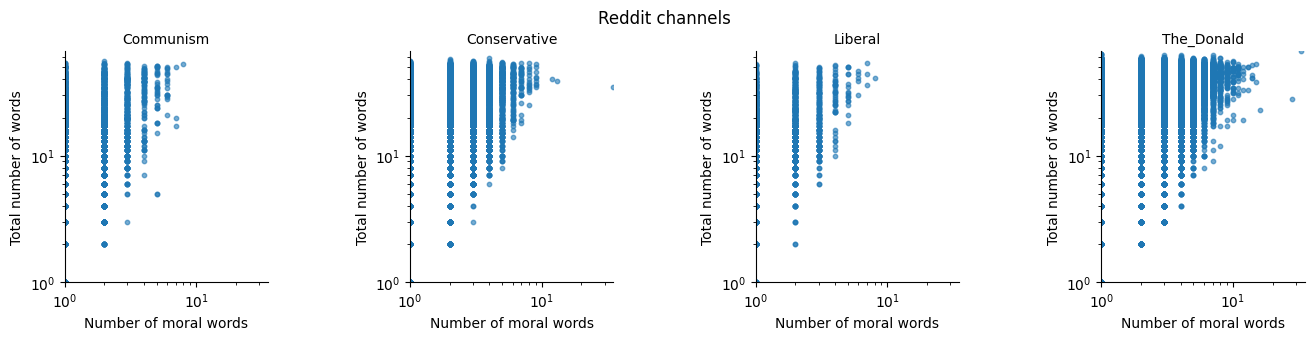

In [33]:
fig, axes = plot_topics_grid(reddit_plots_data, 
                            ["Number of moral words", "Total number of words"],
                            topic_col="channel",
                            xcol="moral_loading", ycol="message_len",
                            cols=4, figsize_per_cell=(4,3),
                            suptitle="Reddit channels",
                            row_gap = 0.8,
                            col_gap = 0.7)
plt.show()

In [137]:
reddit_plots_data['is_video'].value_counts()

is_video
False    1061116
True        6716
Name: count, dtype: int64

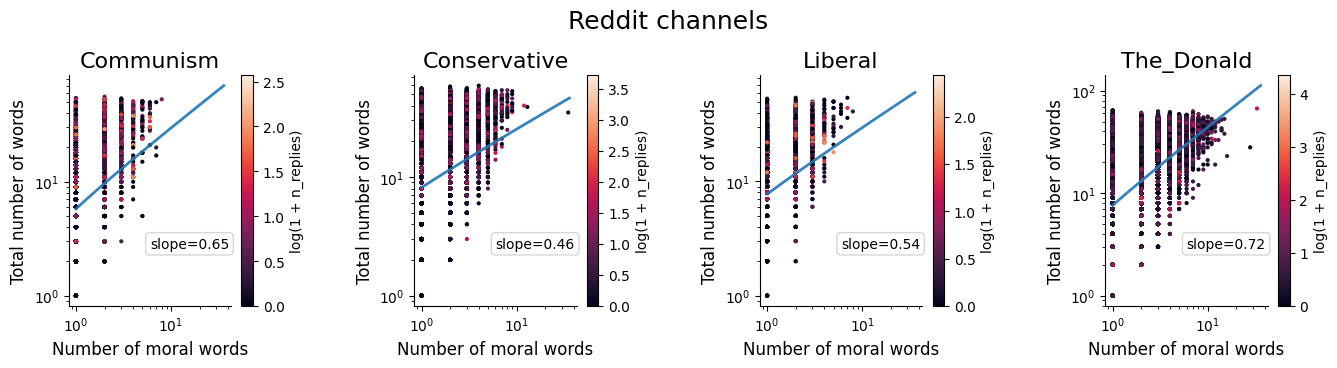

In [44]:
fig, axes, regressors = plot_topics_grid_with_regression(reddit_plots_data, 
                            ["Number of moral words", "Total number of words"],
                            topic_col="channel",
                            xcol="moral_loading", ycol="message_len",
                            cols=4, figsize_per_cell=(4,3),
                            suptitle="Reddit channels",
                            row_gap = 0.8,
                            col_gap = 0.7,
                            eps = 1,
                            is_ddr=False,
                            engagement_col = 'total_n_replies')
plt.show()

/var/folders/2h/91q4sd4x3t13f8n_dy5nkj_00000gn/T/ipykernel_1322/2126592470.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


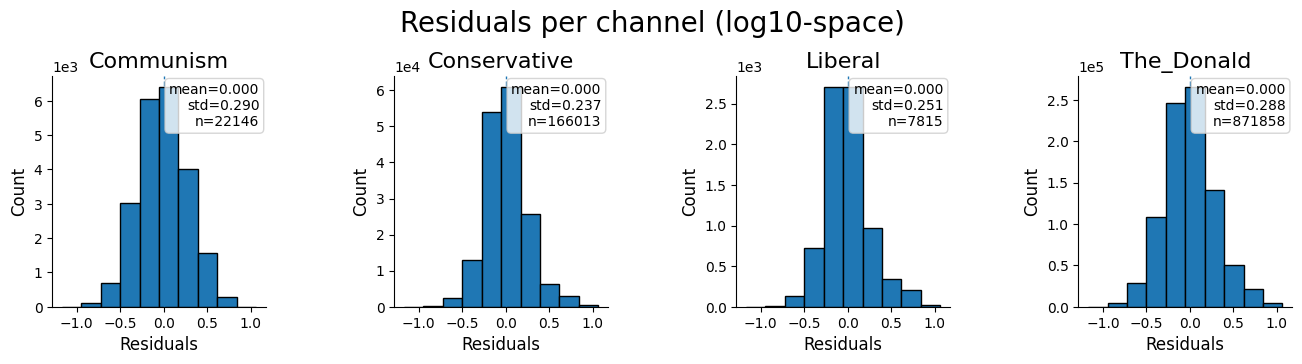

In [45]:
fig, axes, residuals_map, sub_data, _ = plot_residuals_grid(
    reddit_plots_data,
    regressors=regressors,
    topic_col="channel",
    xcol="moral_loading", ycol="message_len",
    cols=4, figsize_per_cell=(4,3),
    bins=10, density=False,
    suptitle="Residuals per channel (log10-space)",
    row_gap=1.0, col_gap=0.6,
    eps=1,
    share_limits=True,
    annotate_stats=True
)
plt.show()

In [46]:
model = 'nb'
coefficients_liwc_reddit = build_per_topic(model, sub_data, residuals_map, is_ddr=False, replies_var='total_n_replies')
coefficients_liwc_reddit["network"] = "Reddit"

Topic label: Communism
residuals | moral density: 0.15749051993931698

Topic label: Conservative
residuals | moral density: 0.20841706959404935

Topic label: Liberal
residuals | moral density: 0.2171906215226735

Topic label: The_Donald
residuals | moral density: 0.17043689953198116



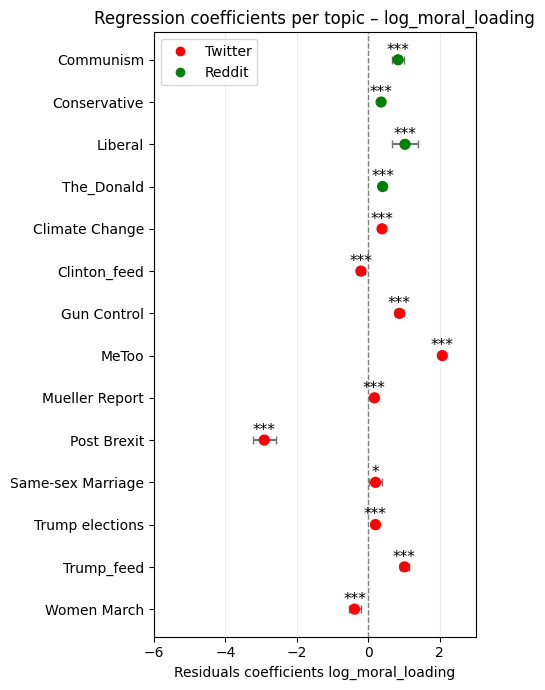

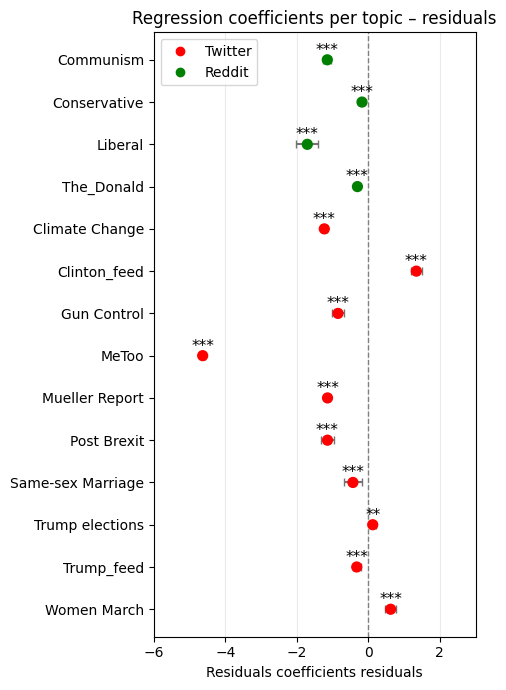

In [50]:
coefficients_liwc = pd.concat((coefficients_liwc_twitter, coefficients_liwc_reddit), axis=0)
vars_uniq = coefficients_liwc["var"].unique()

for var in vars_uniq:
    df_var = coefficients_liwc[coefficients_liwc["var"] == var].copy()

    # sort
    df_var["network"] = pd.Categorical(
        df_var["network"],
        categories=["Twitter", "Reddit"],
        ordered=True
    )

    df_var = df_var.sort_values(["network", "topic"], ascending=[True, False]).reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(5, 7))

    plot_forest_single(
        df_var,
        ax=ax,
        title=f"Regression coefficients per topic – {var}",
        xlab=f"Residuals coefficients {var}",
        left=-6,
        right=3,
    )

    plt.tight_layout()
    plt.show()



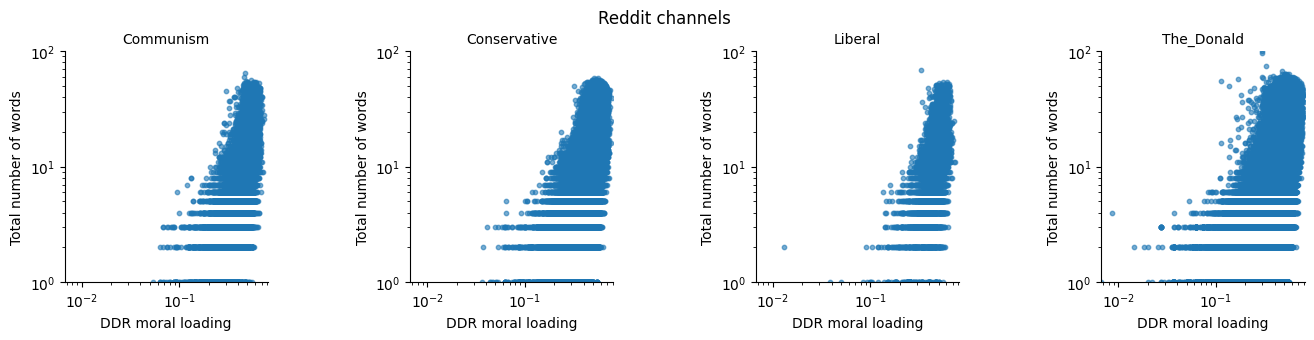

In [69]:
fig, axes = plot_topics_grid(reddit_plots_data, 
                            ["DDR moral loading", "Total number of words"],
                            topic_col="channel",
                            xcol="ddr_moral_loading", ycol="message_len",
                            cols=4, figsize_per_cell=(4,3),
                            suptitle="Reddit channels",
                            row_gap = 0.8,
                            col_gap = 0.7)
plt.show()

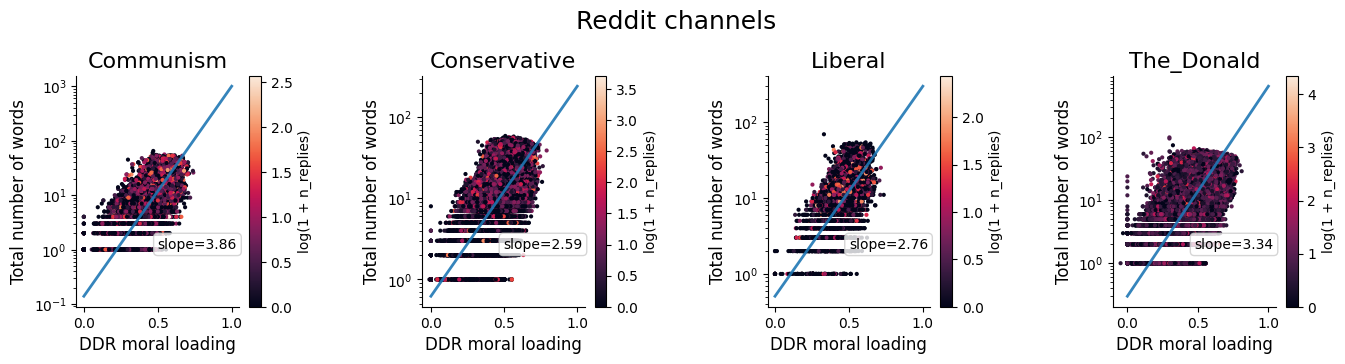

In [58]:
fig, axes, regressors = plot_topics_grid_with_regression(reddit_plots_data, 
                            ["DDR moral loading", "Total number of words"],
                            topic_col="channel",
                            xcol="ddr_moral_loading", ycol="message_len",
                            cols=4, figsize_per_cell=(4,3),
                            suptitle="Reddit channels",
                            row_gap = 0.8,
                            col_gap = 0.7,
                            eps = 1e-6,
                            is_ddr = True,
                            engagement_col='total_n_replies')
plt.show()

/var/folders/2h/91q4sd4x3t13f8n_dy5nkj_00000gn/T/ipykernel_1322/2126592470.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


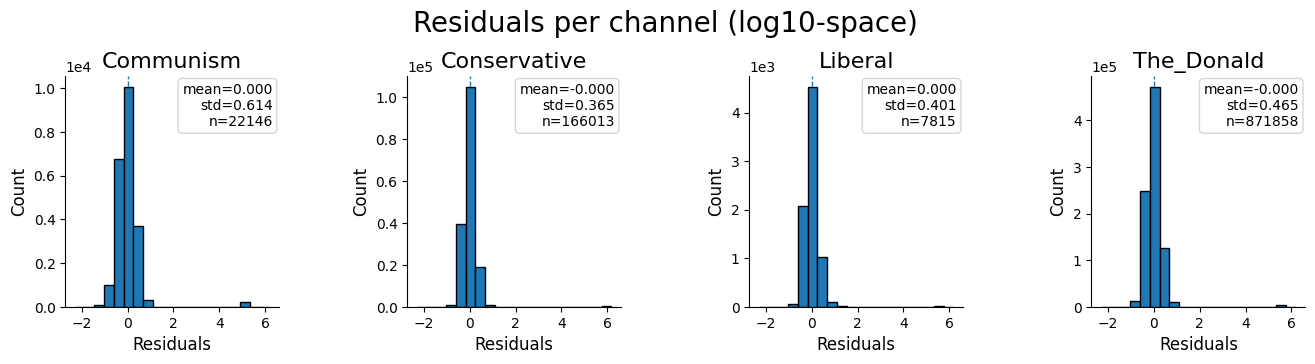

In [59]:
fig, axes, residuals_map, sub_data, _ = plot_residuals_grid(
    reddit_plots_data,
    regressors=regressors,
    topic_col="channel",
    xcol="ddr_moral_loading", ycol="message_len",
    cols=4, figsize_per_cell=(4,3),
    bins=20, density=False,
    suptitle="Residuals per channel (log10-space)",
    row_gap=1.0, col_gap=0.6,
    eps=1e-6,
    share_limits=True,
    annotate_stats=True,
    is_ddr = True
)
plt.show()

In [60]:
model = 'nb'
coefficients_ddr_reddit = build_per_topic(model, sub_data, residuals_map, is_ddr=True, replies_var='total_n_replies')
coefficients_ddr_reddit["network"] = "Reddit"

Topic label: Communism
residuals | moral density: 0.5001313784863152

Topic label: Conservative
residuals | moral density: 0.3141249046384031

Topic label: Liberal
residuals | moral density: 0.3194447466809405

Topic label: The_Donald
residuals | moral density: 0.33713929165267226



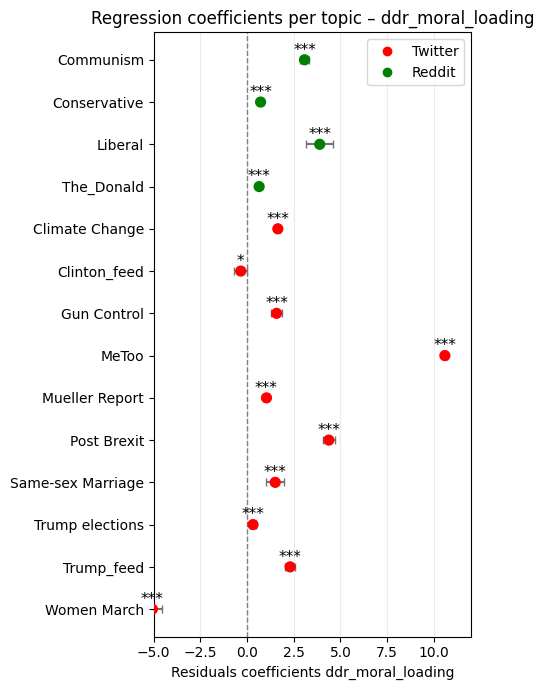

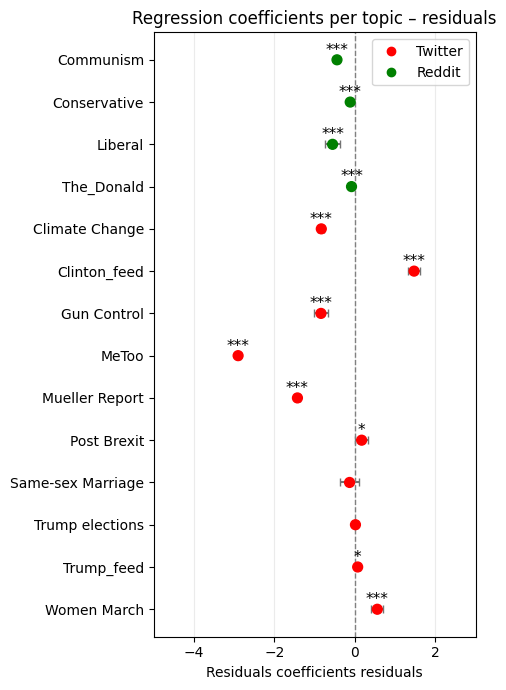

In [63]:
coefficients_ddr = pd.concat((coefficients_ddr_twitter, coefficients_ddr_reddit), axis=0)
vars_uniq = coefficients_ddr["var"].unique()

for var in vars_uniq:
    df_var = coefficients_ddr[coefficients_ddr["var"] == var].copy()

    # sort
    df_var["network"] = pd.Categorical(
        df_var["network"],
        categories=["Twitter", "Reddit"],
        ordered=True
    )

    df_var = df_var.sort_values(["network", "topic"], ascending=[True, False]).reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(5, 7))

    left_lim = -5
    right_lim = 12 if var != "residuals" else 3

    plot_forest_single(
        df_var,
        ax=ax,
        title=f"Regression coefficients per topic – {var}",
        xlab=f"Residuals coefficients {var}",
        left=left_lim,
        right=right_lim,
    )

    plt.tight_layout()
    plt.show()